### Importing libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import Normalizer

In [8]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

### Reading and getting the basic information from the dataset

In [9]:
dataset=pd.read_csv("jm1.csv")
dataset.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,1.30,1.30,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1,1,1,1,1,1,1,1,1,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,0.38,1279.39,51,10,8,1,17,36,112,86,13,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,1.45,4122.37,129,29,28,2,17,135,329,271,5,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,0.20,572.07,28,1,6,0,11,16,76,50,7,True


In [10]:
dataset.shape

(10885, 22)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10885 entries, 0 to 10884
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                10885 non-null  float64
 1   v(g)               10885 non-null  float64
 2   ev(g)              10885 non-null  float64
 3   iv(g)              10885 non-null  float64
 4   n                  10885 non-null  float64
 5   v                  10885 non-null  float64
 6   l                  10885 non-null  float64
 7   d                  10885 non-null  float64
 8   i                  10885 non-null  float64
 9   e                  10885 non-null  float64
 10  b                  10885 non-null  float64
 11  t                  10885 non-null  float64
 12  lOCode             10885 non-null  int64  
 13  lOComment          10885 non-null  int64  
 14  lOBlank            10885 non-null  int64  
 15  locCodeAndComment  10885 non-null  int64  
 16  uniq_Op            108

In [13]:
dataset.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

No missing values in any column

In [14]:
dataset.select_dtypes(include='object').describe()

,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,10885,10885,10885,10885,10885
unique,69,172,582,469,147
top,0,0,0,0,1
freq,1332,1368,1332,1368,2636


Object columns if required for modelling, need to be converted to numeric type

In [15]:
dataset.select_dtypes(exclude='object').describe().T

,count,mean,std,min,25%,50%,75%,max
loc,10885.0,42.016178,76.593332,1.0,11.00,23.00,46.00,3442.00
v(g),10885.0,6.348590,13.019695,1.0,2.00,3.00,7.00,470.00
ev(g),10885.0,3.401047,6.771869,1.0,1.00,1.00,3.00,165.00
iv(g),10885.0,4.001599,9.116889,1.0,1.00,2.00,4.00,402.00
n,10885.0,114.389738,249.502091,0.0,14.00,49.00,119.00,8441.00
v,10885.0,673.758017,1938.856196,0.0,48.43,217.13,621.48,80843.08
l,10885.0,0.135335,0.160538,0.0,0.03,0.08,0.16,1.30
d,10885.0,14.177237,18.709900,0.0,3.00,9.09,18.90,418.20
i,10885.0,29.439544,34.418313,0.0,11.86,21.93,36.78,569.78
e,10885.0,36836.365343,434367.801255,0.0,161.94,2031.02,11416.43,31079782.27


The values of columns -n,v,e and t are at different range when compared with other columns so need scaling

### Pandas pre-profiling of the dataset

In [0]:
#!pip install pandas_profiling==2.5.0 --user
#import pandas_profiling

#report = pandas_profiling.ProfileReport(dataset)
#report.to_file("Pre_profiling_software_defect.html")

- 18.1 % duplicate rows
- unique_Op,unique_Opnd,total_Op,total_Opnd,branchCount have high number of unique values, which seems fine as these contains the information of operators and operands used in the code which could be high in number.
- v is highly correlated with loc,n,b,IOCode
- loc is highly correlated with v, IOCode
- n is highly correlated with v,b,IOCode
- b is highly correlated with n,v,IOCode
- t is highly correlated with e
- IOCode is highly correlated with loc,n,v,b
- lot of zeroes in the multiple columns
- skewness in columns

Action plan
 - check and remove duplicare rows
 - Model can be tested with and without high correlated columns
 - Scaling/Normalization and outlier removal needed to handle skewness 

In [16]:
dataset.defects.value_counts()

False    8779
True     2106
Name: defects, dtype: int64

False is around 81% and True is around 19%, so we may have issue with data imbalance if model always predicts one particular class ie. False, we will consider it after basic model prediction

## EDA

**Duplicate rows checking and handling**

In [17]:
dataset_orig=dataset.copy()
dataset.drop_duplicates(keep='first', inplace=True)
dataset.shape

(8912, 22)

In [18]:
dataset.defects.value_counts()

False    6905
True     2007
Name: defects, dtype: int64

False is around 77% and True around 24%

**Outlier checking**

In [19]:
df_data_numeric=dataset.select_dtypes(exclude=['object', 'bool'])
df_data_object=dataset.select_dtypes(include=['object', 'bool'])
df_numeric_dsc=df_data_numeric.describe()
df_numeric_dsc

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment
count,8912.000000,8912.000000,8912.000000,8912.000000,8912.000000,8912.00000,8912.000000,8912.000000,8912.00000,8.912000e+03,8912.000000,8.912000e+03,8912.000000,8912.000000,8912.000000,8912.000000
mean,48.945815,7.312545,3.846432,4.547285,135.149046,802.93798,0.099221,16.308482,33.32800,4.458978e+04,0.267882,2.477210e+03,30.976324,3.301616,5.493941,0.443447
std,82.878304,14.164716,7.362449,9.967929,270.798330,2119.05428,0.106966,19.709877,36.61028,4.796844e+05,0.706469,2.664913e+04,64.839015,9.857652,10.797946,2.096149
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,15.000000,2.000000,1.000000,1.000000,26.000000,102.19000,0.030000,5.337500,14.88750,5.808000e+02,0.030000,3.227000e+01,7.000000,0.000000,1.000000,0.000000
50%,27.000000,4.000000,1.000000,2.000000,64.000000,298.06000,0.070000,11.270000,25.28500,3.422705e+03,0.100000,1.901500e+02,16.000000,0.000000,3.000000,0.000000
75%,55.000000,8.000000,4.000000,5.000000,141.000000,747.88000,0.130000,21.222500,40.76250,1.528194e+04,0.250000,8.490000e+02,34.000000,3.000000,6.000000,0.000000
max,3442.000000,470.000000,165.000000,402.000000,8441.000000,80843.08000,1.300000,418.200000,569.78000,3.107978e+07,26.950000,1.726655e+06,2824.000000,344.000000,447.000000,108.000000


In [20]:
df_data_object.describe()

,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
count,8912,8912,8912,8912,8912,8912
unique,69,172,582,469,147,2
top,0,0,0,0,3,False
freq,971,990,971,990,1419,6905


In [0]:
def check_and_count_outliers(df1, df2, title, color):
    outlier_dict={}
    outlier_df=pd.DataFrame()
    for col in df1.columns:   
        IQR=df2.loc['75%'][col]-df2.loc['25%'][col]
        IQR=IQR*1.5
        upper_limit=df2.loc['75%'][col] + IQR
        lower_limit=df2.loc['25%'][col]-IQR
        num=len(df1[(df1[col]<lower_limit) | (df1[col]>upper_limit)][col])
        if num>0:
            outlier_dict[col]=num
    outlier_df=pd.DataFrame(outlier_dict, index=[0]).T
    outlier_df.columns=['outliers']

    plt.rcParams["figure.figsize"] = [8,6]
    outlier_df.plot(kind='bar', color=color)
    plt.xlabel("Column names")
    plt.ylabel("Number of outliers")
    plt.title(title)
    plt.tight_layout()

    return outlier_df

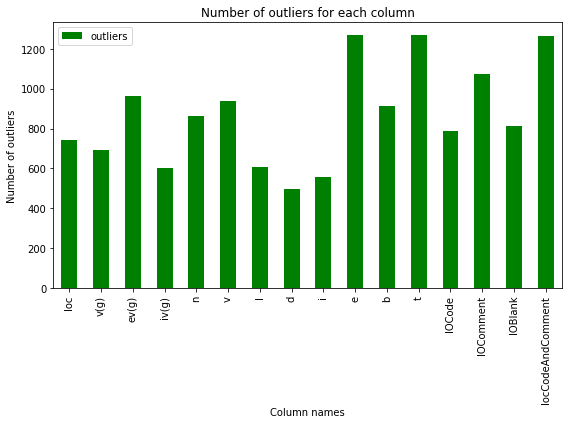

In [22]:
original_outlier_df=check_and_count_outliers(df_data_numeric, df_numeric_dsc, "Number of outliers for each column", 'g')
plt.show()

In [23]:
original_outlier_df

,outliers
loc,741
v(g),692
ev(g),965
iv(g),602
n,865
v,936
l,608
d,497
i,559
e,1269


In [0]:
def plot_columns_outliers(df, c, numr, numc):
    fig, axes=plt.subplots(nrows=numr, ncols=numc, sharex=False, sharey=False, figsize=(20, 20))
    for ax, column in zip(axes.flat, df.columns):
        sns.boxplot(df[column], ax=ax, color=c)

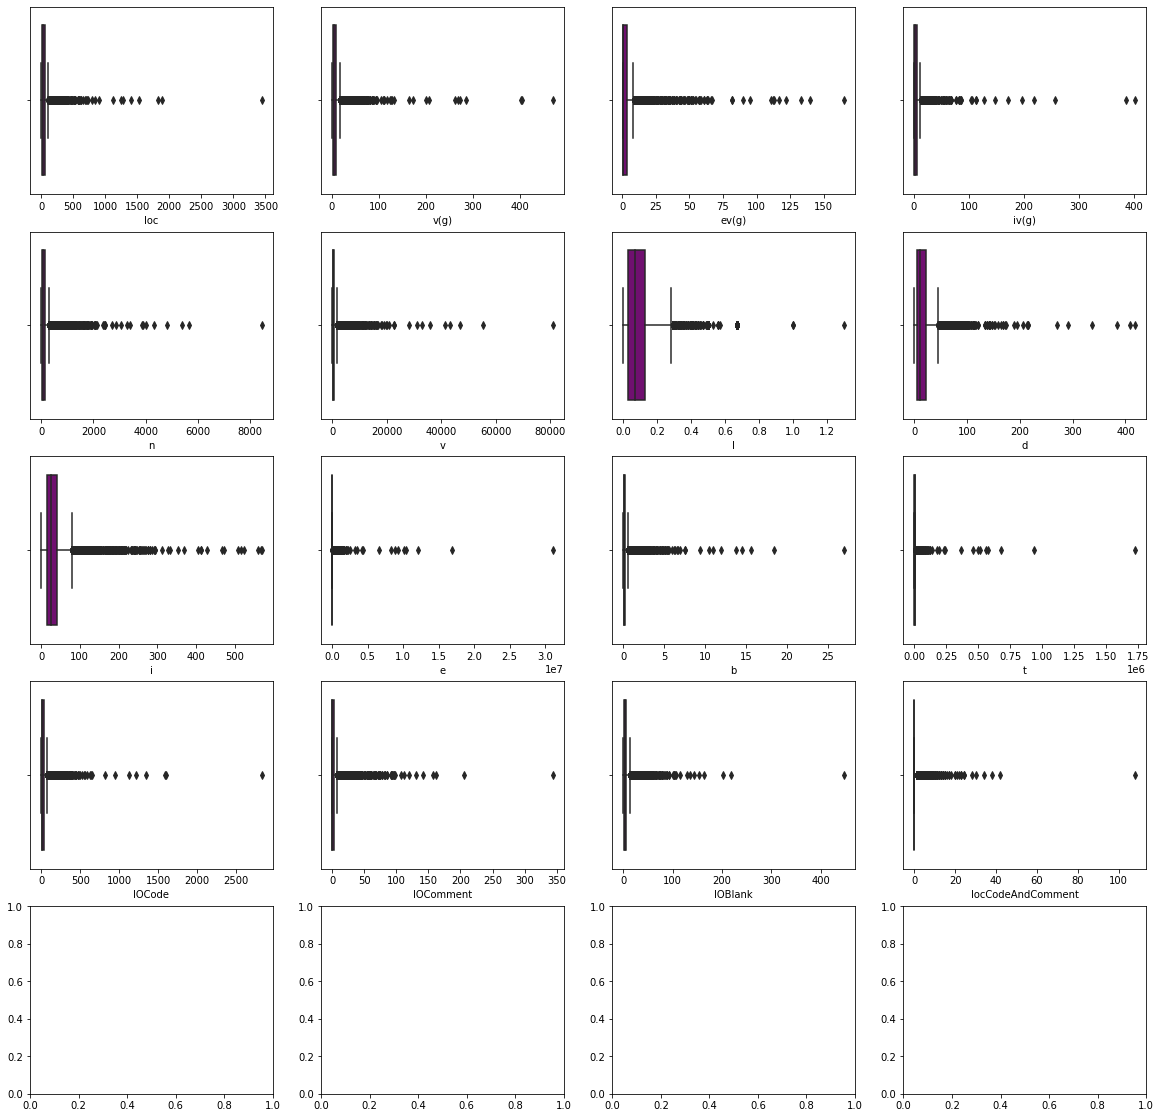

In [25]:
plot_columns_outliers(df_data_numeric, 'purple', 5, 4)
plt.show()

**Data distribution**

In [0]:
import scipy.stats as stats

In [0]:
def get_kurtosis(df, kurt_threshold):
    kurt_dict={}
    for col in df.columns:
        val=stats.kurtosis(df[col], bias=False)
    if (val>=kurt_threshold):
        kurt_dict[col]=val
    return pd.DataFrame(kurt_dict, index=[0]).T.dropna()

In [28]:
df_numeric_kurt_data=get_kurtosis(df_data_numeric, 3)
df_numeric_kurt_data

,0
locCodeAndComment,838.900908


In [0]:
def get_skew(df, minval, maxval):
    skew_dict={}
    for col in df.columns:
        val=stats.skew(df[col], bias=False)
        if ((val<minval) | (val>maxval)):
            skew_dict[col]=val
    return pd.DataFrame(skew_dict, index=[0]).T.dropna()

In [30]:
df_numeric_skew_data=get_skew(df_data_numeric, -1, 1)
df_numeric_skew_data

,0
loc,14.057100
v(g),14.236258
ev(g),7.583095
iv(g),19.912158
n,9.802648
v,14.479064
l,2.445387
d,5.961897
i,4.951373
e,41.863934


In [0]:
def plot_columns_distribution(df, title, c, numr, numc):
    fig, axes=plt.subplots(nrows=numr, ncols=numc, sharex=False, sharey=False, figsize=(30, 20))
    for ax, column in zip(axes.flat, df.columns):
        sns.distplot(df[column], ax=ax, color=c)

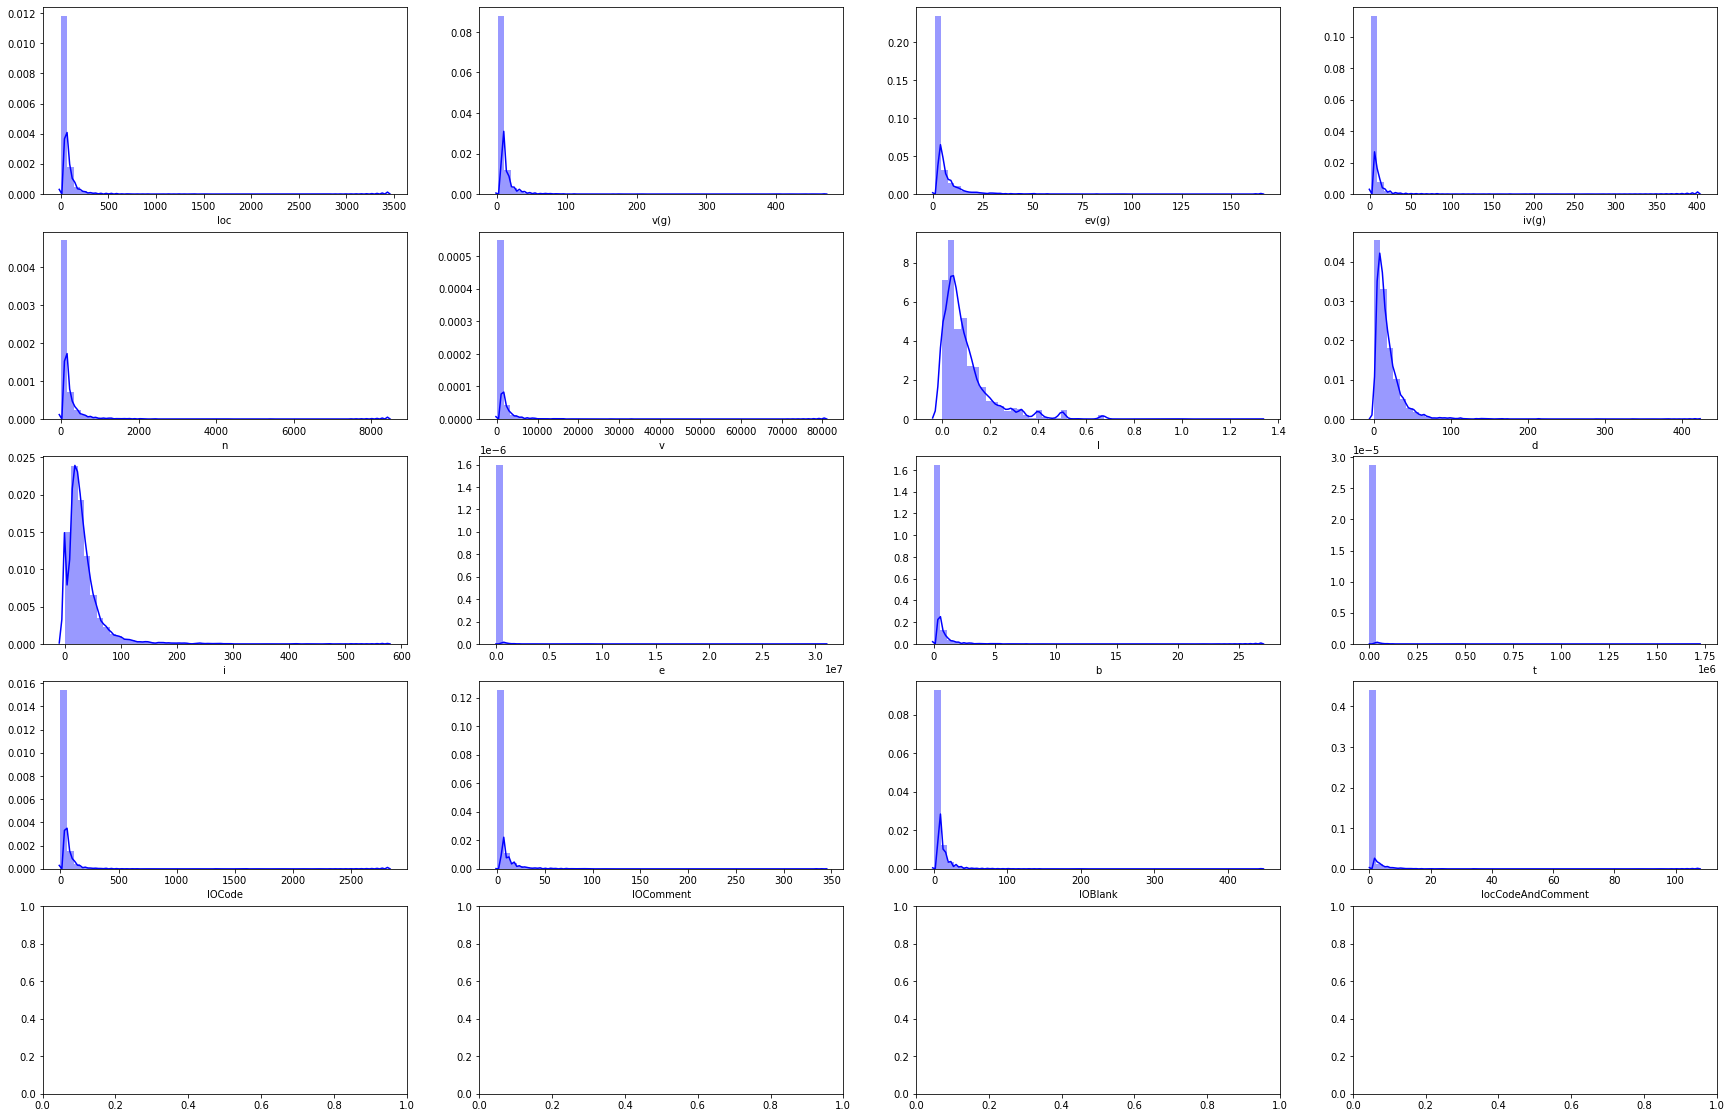

In [32]:
plot_columns_distribution(df_data_numeric, "Distribution", 'blue', 5, 4)
plt.show()

The numeric fields have high skewness which needs to be rectified to make data more normalized.

### Data Preprocessing

**Converting non-numeric columns to numeric**

In [33]:
df_data_object.head()

,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.2,1.2,1.2,1.2,1.4,False
1,1,1,1,1,1,True
2,17,36,112,86,13,True
3,17,135,329,271,5,True
4,11,16,76,50,7,True


In [34]:
df_data_object.uniq_Op.unique()

array(['1.2', '1', '17', '11', '14', '0', '4', '19', '32', '7', '26',
       '27', '21', '9', '28', '22', '16', '8', '20', '10', '13', '25',
       '12', '5', '34', '15', '6', '18', '24', '30', '?', '23', '3', '38',
       '29', '33', '39', '45', '31', '58', '37', '49', '48', '410', '35',
       '36', '42', '40', '46', '44', '41', '52', '74', '280', '65', '73',
       '61', '78', '172', '105', '102', '98', '411', '155', '2', '55',
       '43', '47', '99'], dtype=object)

In [0]:
df_data_object.uniq_Op=df_data_object.uniq_Op.str.replace('?',df_data_object.uniq_Op.mode()[0])

In [36]:
df_data_object.uniq_Opnd.unique()

array(['1.2', '1', '36', '135', '16', '24', '0', '5', '12', '23', '4',
       '64', '10', '47', '59', '56', '113', '25', '103', '29', '44', '21',
       '28', '7', '15', '57', '63', '53', '6', '76', '51', '30', '17',
       '8', '19', '18', '52', '32', '20', '40', '22', '86', '3', '78',
       '14', '11', '68', '38', '9', '13', '42', '67', '49', '?', '43',
       '34', '27', '33', '45', '26', '48', '46', '35', '87', '101', '104',
       '165', '126', '75', '112', '62', '77', '162', '31', '138', '80',
       '160', '58', '69', '60', '70', '2', '50', '71', '175', '39', '37',
       '54', '73', '65', '41', '66', '85', '95', '74', '94', '102', '88',
       '147', '117', '84', '55', '81', '132', '61', '140', '96', '90',
       '146', '806', '154', '110', '241', '128', '99', '119', '127',
       '164', '91', '142', '72', '89', '137', '174', '122', '93', '108',
       '83', '256', '176', '152', '100', '134', '79', '82', '115', '215',
       '133', '182', '183', '97', '111', '109', '549', '157

In [0]:
df_data_object.uniq_Opnd=df_data_object.uniq_Opnd.str.replace('?',df_data_object.uniq_Opnd.mode()[0])

In [38]:
df_data_object.total_Op.unique()

array(['1.2', '1', '112', '329', '76', '69', '0', '9', '22', '87', '5',
       '1081', '167', '161', '176', '107', '299', '72', '484', '45',
       '388', '127', '85', '18', '66', '21', '113', '15', '34', '31',
       '308', '149', '58', '38', '271', '174', '29', '8', '256', '10',
       '370', '158', '24', '116', '40', '27', '47', '260', '86', '12',
       '6', '44', '165', '7', '164', '153', '106', '13', '19', '246',
       '53', '33', '191', '83', '123', '80', '132', '111', '43', '67',
       '258', '211', '184', '96', '49', '63', '51', '61', '68', '28',
       '201', '118', '?', '156', '125', '202', '78', '98', '925', '73',
       '4', '14', '46', '122', '119', '54', '89', '324', '11', '55', '57',
       '36', '88', '84', '192', '239', '35', '70', '148', '77', '139',
       '210', '229', '145', '23', '41', '32', '39', '42', '82', '65',
       '166', '141', '48', '268', '175', '64', '683', '105', '186', '117',
       '26', '94', '137', '455', '261', '135', '364', '616', '691',
     

In [0]:
df_data_object.total_Op=df_data_object.total_Op.str.replace('?',df_data_object.total_Op.mode()[0])

In [40]:
df_data_object.total_Opnd.unique()

array(['1.2', '1', '86', '271', '50', '42', '0', '7', '15', '4', '388',
       '117', '118', '146', '64', '227', '73', '330', '43', '310', '91',
       '72', '13', '10', '79', '6', '18', '20', '208', '77', '48', '33',
       '220', '126', '189', '274', '115', '16', '74', '39', '28', '76',
       '23', '142', '41', '71', '5', '140', '29', '123', '11', '113',
       '124', '70', '8', '202', '45', '3', '26', '161', '54', '103', '51',
       '63', '84', '163', '204', '139', '40', '38', '17', '36', '44',
       '30', '52', '9', '21', '105', '?', '19', '104', '80', '147', '65',
       '34', '14', '304', '12', '37', '57', '32', '257', '24', '22', '35',
       '153', '143', '47', '90', '87', '27', '198', '93', '96', '133',
       '62', '107', '89', '60', '415', '49', '68', '25', '94', '379',
       '225', '108', '67', '329', '570', '546', '210', '696', '383',
       '604', '131', '127', '382', '120', '939', '720', '406', '834',
       '197', '288', '293', '175', '55', '59', '171', '81', '83', 

In [0]:
df_data_object.total_Opnd=df_data_object.total_Opnd.str.replace('?',df_data_object.total_Opnd.mode()[0])

In [42]:
df_data_object.branchCount.unique()

array(['1.4', '1', '13', '5', '7', '3', '17', '43', '19', '21', '15',
       '97', '33', '11', '69', '85', '9', '31', '41', '47', '25', '37',
       '39', '29', '219', '53', '109', '71', '27', '58', '22', '24', '35',
       '45', '23', '?', '18', '14', '61', '34', '20', '51', '67', '49',
       '75', '74', '4', '187', '16', '55', '175', '92', '42', '91', '95',
       '6', '8', '46', '52', '12', '59', '57', '10', '65', '28', '26',
       '144', '233', '169', '86', '133', '127', '101', '221', '99', '48',
       '159', '189', '63', '83', '73', '89', '64', '38', '145', '79',
       '245', '265', '60', '32', '401', '403', '84', '30', '77', '151',
       '149', '115', '113', '181', '81', '107', '137', '96', '105', '125',
       '87', '179', '161', '147', '153', '36', '121', '129', '139', '111',
       '274', '135', '338', '503', '240', '344', '485', '464', '405',
       '211', '826', '163', '98', '119', '93', '76', '54', '50', '72',
       '120', '128', '152', '106', '131', '40', '329', '143

In [0]:
df_data_object.branchCount=df_data_object.branchCount.str.replace('?',df_data_object.branchCount.mode()[0])

In [0]:
df_data_object.defects=df_data_object.defects.astype('int64')

In [45]:
df_data_object.head()

,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.2,1.2,1.2,1.2,1.4,0
1,1,1,1,1,1,1
2,17,36,112,86,13,1
3,17,135,329,271,5,1
4,11,16,76,50,7,1


In [46]:
df_data_object.uniq_Op=pd.to_numeric(df_data_object.uniq_Op, errors='coerce')
df_data_object.uniq_Op

0         1.2
1         1.0
2        17.0
3        17.0
4        11.0
         ... 
10880    10.0
10881    12.0
10882    18.0
10883     9.0
10884    12.0
Name: uniq_Op, Length: 8912, dtype: float64

In [47]:
df_data_object.uniq_Opnd=pd.to_numeric(df_data_object.uniq_Opnd, errors='coerce')
df_data_object.uniq_Opnd

0          1.2
1          1.0
2         36.0
3        135.0
4         16.0
         ...  
10880     15.0
10881      8.0
10882     15.0
10883      8.0
10884     14.0
Name: uniq_Opnd, Length: 8912, dtype: float64

In [48]:
df_data_object.total_Op=pd.to_numeric(df_data_object.total_Op, errors='coerce')
df_data_object.total_Op

0          1.2
1          1.0
2        112.0
3        329.0
4         76.0
         ...  
10880     30.0
10881     19.0
10882     59.0
10883     21.0
10884     31.0
Name: total_Op, Length: 8912, dtype: float64

In [49]:
df_data_object.total_Opnd=pd.to_numeric(df_data_object.total_Opnd, errors='coerce')
df_data_object.total_Opnd

0          1.2
1          1.0
2         86.0
3        271.0
4         50.0
         ...  
10880     22.0
10881     11.0
10882     44.0
10883     15.0
10884     27.0
Name: total_Opnd, Length: 8912, dtype: float64

In [50]:
df_data_object.branchCount=pd.to_numeric(df_data_object.branchCount, errors='coerce')
df_data_object.branchCount

0         1.4
1         1.0
2        13.0
3         5.0
4         7.0
         ... 
10880     7.0
10881     3.0
10882     7.0
10883     1.0
10884     5.0
Name: branchCount, Length: 8912, dtype: float64

In [51]:
df_data_object.head()

,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.2,1.2,1.2,1.2,1.4,0
1,1.0,1.0,1.0,1.0,1.0,1
2,17.0,36.0,112.0,86.0,13.0,1
3,17.0,135.0,329.0,271.0,5.0,1
4,11.0,16.0,76.0,50.0,7.0,1


In [52]:
df_data_object.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8912 entries, 0 to 10884
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uniq_Op      8912 non-null   float64
 1   uniq_Opnd    8912 non-null   float64
 2   total_Op     8912 non-null   float64
 3   total_Opnd   8912 non-null   float64
 4   branchCount  8912 non-null   float64
 5   defects      8912 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 487.4 KB


**Combining df_data_object and df_data_numeric**

In [0]:
dataset_upd=pd.concat([df_data_numeric, df_data_object], axis=1)

In [54]:
dataset_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8912 entries, 0 to 10884
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                8912 non-null   float64
 1   v(g)               8912 non-null   float64
 2   ev(g)              8912 non-null   float64
 3   iv(g)              8912 non-null   float64
 4   n                  8912 non-null   float64
 5   v                  8912 non-null   float64
 6   l                  8912 non-null   float64
 7   d                  8912 non-null   float64
 8   i                  8912 non-null   float64
 9   e                  8912 non-null   float64
 10  b                  8912 non-null   float64
 11  t                  8912 non-null   float64
 12  lOCode             8912 non-null   int64  
 13  lOComment          8912 non-null   int64  
 14  lOBlank            8912 non-null   int64  
 15  locCodeAndComment  8912 non-null   int64  
 16  uniq_Op            8912

In [55]:
dataset_upd.shape

(8912, 22)

In [56]:
dataset_upd.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [57]:
dataset_upd.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,1.30,1.30,2,2,2,2,1.2,1.2,1.2,1.2,1.4,0
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,0.38,1279.39,51,10,8,1,17.0,36.0,112.0,86.0,13.0,1
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,1.45,4122.37,129,29,28,2,17.0,135.0,329.0,271.0,5.0,1
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,0.20,572.07,28,1,6,0,11.0,16.0,76.0,50.0,7.0,1


In [0]:
#dataset_upd.defects=dataset_upd.defects.astype('category',copy=False)

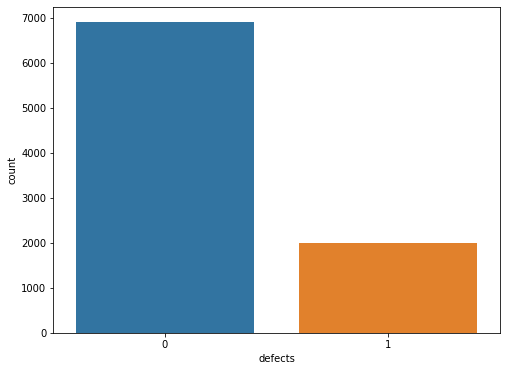

In [58]:
sns.countplot(x='defects', data=dataset_upd)

In [59]:
dataset_upd.defects.value_counts()

0    6905
1    2007
Name: defects, dtype: int64

In [60]:
dataset_upd.describe().T

,count,mean,std,min,25%,50%,75%,max
loc,8912.0,48.945815,82.878304,1.0,15.0000,27.000,55.0000,3442.00
v(g),8912.0,7.312545,14.164716,1.0,2.0000,4.000,8.0000,470.00
ev(g),8912.0,3.846432,7.362449,1.0,1.0000,1.000,4.0000,165.00
iv(g),8912.0,4.547285,9.967929,1.0,1.0000,2.000,5.0000,402.00
n,8912.0,135.149046,270.798330,0.0,26.0000,64.000,141.0000,8441.00
v,8912.0,802.937980,2119.054280,0.0,102.1900,298.060,747.8800,80843.08
l,8912.0,0.099221,0.106966,0.0,0.0300,0.070,0.1300,1.30
d,8912.0,16.308482,19.709877,0.0,5.3375,11.270,21.2225,418.20
i,8912.0,33.328000,36.610280,0.0,14.8875,25.285,40.7625,569.78
e,8912.0,44589.783611,479684.376310,0.0,580.8000,3422.705,15281.9450,31079782.27


**Remove outliers**

In [0]:
def drop_outliers(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    return df[~((df<(Q1 - 1.5 * IQR)) | (df>(Q3 + 1.5 * IQR))).any(axis=1)]

In [0]:
dataset_upd_nout=dataset_upd.copy()

**Data imbalance fix**

In [0]:
X1=dataset_upd_nout.drop('defects', axis=1)
y1=dataset_upd_nout.loc[:,'defects']

In [0]:
oversample = SMOTE()
X1, y1 = oversample.fit_resample(X1, y1)

In [85]:
X1.shape

(13810, 21)

In [94]:
pd.DataFrame(X1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.100000,1.400000,1.400000,1.400000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,2.000000,2.000000,2.000000,2.000000,1.200000,1.200000,1.200000,1.200000,1.400000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,72.000000,7.000000,1.000000,6.000000,198.000000,1134.130000,0.050000,20.310000,55.850000,23029.100000,0.380000,1279.390000,51.000000,10.000000,8.000000,1.000000,17.000000,36.000000,112.000000,86.000000,13.000000
3,190.000000,3.000000,1.000000,3.000000,600.000000,4348.760000,0.060000,17.060000,254.870000,74202.670000,1.450000,4122.370000,129.000000,29.000000,28.000000,2.000000,17.000000,135.000000,329.000000,271.000000,5.000000
4,37.000000,4.000000,1.000000,4.000000,126.000000,599.120000,0.060000,17.190000,34.860000,10297.300000,0.200000,572.070000,28.000000,1.000000,6.000000,0.000000,11.000000,16.000000,76.000000,50.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,84.152013,8.650183,1.000000,2.300366,260.593413,1325.251770,0.026502,36.034617,37.439558,47323.724653,0.442015,2629.096175,57.049451,5.201464,12.749085,2.600732,14.802196,24.954209,144.243596,116.349817,16.300366
13806,79.815560,16.912642,3.097083,4.097083,218.805835,1304.575088,0.033010,28.547760,46.186723,37054.362399,0.431068,2058.569303,66.825285,0.000000,3.699028,5.893193,24.912642,39.223340,129.912642,88.893193,25.601945
13807,237.906261,2.610120,2.610120,2.610120,1267.995449,9373.888134,0.030000,29.756607,315.012224,278942.646993,3.125342,15496.816377,169.194940,15.686021,51.025300,0.000000,16.635420,154.668184,710.688933,557.306516,4.220240
13808,142.030394,24.816739,8.862554,13.465639,429.931277,2659.754599,0.020000,42.597115,62.768202,113027.241979,0.889084,6279.291429,113.847133,9.068723,15.068723,2.045815,24.954185,48.770924,266.206168,163.725109,48.144932


In [86]:
y1.shape

(13810,)

In [0]:
y1=y1[:,np.newaxis]

In [89]:
y1.shape

(13810, 1)

In [95]:
pd.DataFrame(y1)

,0
0,0
1,1
2,1
3,1
4,1
...,...
13805,1
13806,1
13807,1
13808,1


In [101]:
dataset_upd_nout_smt=pd.concat([pd.DataFrame(X1),pd.DataFrame(y1)], axis=1)
dataset_upd_nout_smt.columns=dataset_upd_nout.columns
dataset_upd_nout_smt

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.100000,1.400000,1.400000,1.400000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,2.000000,2.000000,2.000000,2.000000,1.200000,1.200000,1.200000,1.200000,1.400000,0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,72.000000,7.000000,1.000000,6.000000,198.000000,1134.130000,0.050000,20.310000,55.850000,23029.100000,0.380000,1279.390000,51.000000,10.000000,8.000000,1.000000,17.000000,36.000000,112.000000,86.000000,13.000000,1
3,190.000000,3.000000,1.000000,3.000000,600.000000,4348.760000,0.060000,17.060000,254.870000,74202.670000,1.450000,4122.370000,129.000000,29.000000,28.000000,2.000000,17.000000,135.000000,329.000000,271.000000,5.000000,1
4,37.000000,4.000000,1.000000,4.000000,126.000000,599.120000,0.060000,17.190000,34.860000,10297.300000,0.200000,572.070000,28.000000,1.000000,6.000000,0.000000,11.000000,16.000000,76.000000,50.000000,7.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,84.152013,8.650183,1.000000,2.300366,260.593413,1325.251770,0.026502,36.034617,37.439558,47323.724653,0.442015,2629.096175,57.049451,5.201464,12.749085,2.600732,14.802196,24.954209,144.243596,116.349817,16.300366,1
13806,79.815560,16.912642,3.097083,4.097083,218.805835,1304.575088,0.033010,28.547760,46.186723,37054.362399,0.431068,2058.569303,66.825285,0.000000,3.699028,5.893193,24.912642,39.223340,129.912642,88.893193,25.601945,1
13807,237.906261,2.610120,2.610120,2.610120,1267.995449,9373.888134,0.030000,29.756607,315.012224,278942.646993,3.125342,15496.816377,169.194940,15.686021,51.025300,0.000000,16.635420,154.668184,710.688933,557.306516,4.220240,1
13808,142.030394,24.816739,8.862554,13.465639,429.931277,2659.754599,0.020000,42.597115,62.768202,113027.241979,0.889084,6279.291429,113.847133,9.068723,15.068723,2.045815,24.954185,48.770924,266.206168,163.725109,48.144932,1


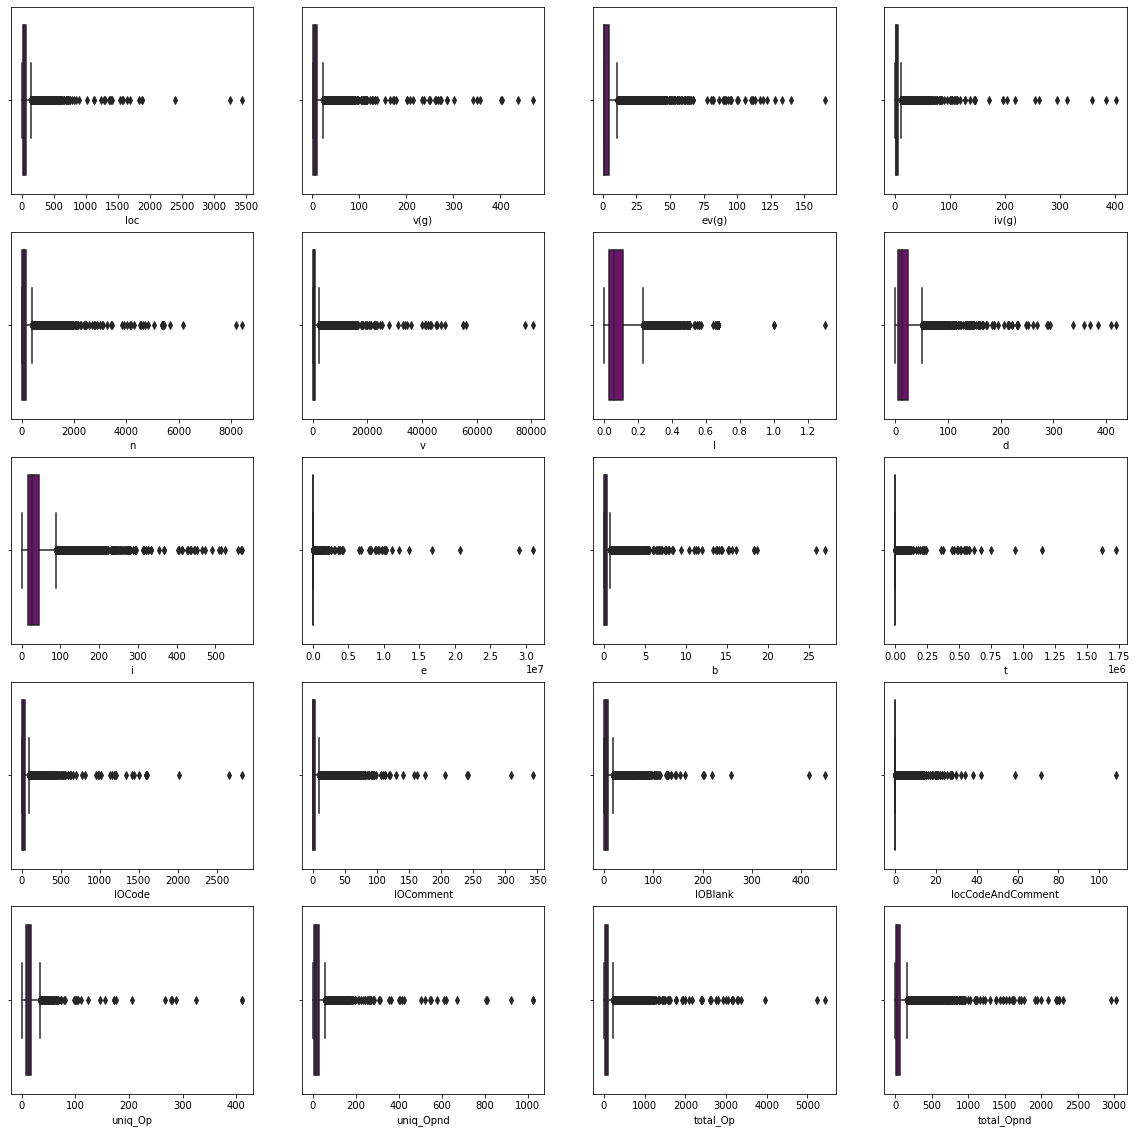

In [102]:
plot_columns_outliers(dataset_upd_nout_smt, 'purple', 5, 4)

In [103]:
dataset_upd_nout_smt1=drop_outliers(dataset_upd_nout_smt).copy()
dataset_upd_nout_smt1.reset_index(drop=True, inplace=True)
dataset_upd_nout_smt1.describe()


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
count,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.0,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000
mean,31.188805,4.642654,2.424491,2.974654,68.115553,344.288049,0.078423,11.509160,23.997287,6274.225283,0.114724,348.567997,16.967180,1.059277,3.190454,0.0,10.823039,13.012162,40.593313,27.509641,8.143396,0.408003
std,21.061359,3.158950,2.301575,1.954987,59.212805,333.951427,0.056751,8.716227,17.172775,9040.968480,0.111295,502.276086,14.329647,2.079157,3.123210,0.0,6.250552,9.956939,35.078165,24.722382,6.205597,0.491495
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,17.000000,2.000000,1.000000,2.000000,26.000000,102.800000,0.040000,5.850000,13.100000,670.371319,0.030000,37.242409,7.000000,0.000000,1.000000,0.0,8.000000,6.000000,16.000000,10.000000,3.000000,0.000000
50%,25.000000,4.000000,1.000000,2.128791,54.000000,247.590000,0.070000,10.000000,22.775533,2466.050000,0.080000,137.000000,14.000000,0.000000,2.835338,0.0,11.392620,12.000000,32.571475,21.197027,7.000000,0.000000
75%,40.000000,6.000000,3.000000,4.000000,100.000000,505.007384,0.113772,16.360000,33.780000,7994.381013,0.170000,444.130445,24.000000,1.000000,5.000000,0.0,15.000000,19.000000,59.000000,40.000000,11.000000,1.000000
max,146.158356,20.280278,11.000000,12.000000,369.000000,1991.380000,0.228942,47.810000,88.480000,53255.140000,0.660000,2958.620000,92.000000,10.000000,18.381896,0.0,33.000000,56.000000,227.000000,158.000000,38.058194,1.000000


In [0]:
X=dataset_upd_nout_smt1.drop('defects', axis=1)
y=dataset_upd_nout_smt1.loc[:,'defects']

In [105]:
corr=X.corr().abs()
corr

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
loc,1.000000,0.680873,0.373769,0.622004,0.348848,0.389481,0.568519,0.163131,0.119909,0.432656,0.389306,0.432656,0.389910,0.229479,0.312015,NaN,0.001803,0.241565,0.341999,0.348553,0.674858
v(g),0.680873,1.000000,0.701162,0.710787,0.258895,0.291568,0.548751,0.250914,0.041049,0.397030,0.291153,0.397030,0.309809,0.095239,0.126943,NaN,0.094162,0.131818,0.260618,0.252993,0.988309
ev(g),0.373769,0.701162,1.000000,0.430539,0.093352,0.119734,0.414708,0.149964,0.139393,0.224673,0.119535,0.224673,0.079523,0.049800,0.011677,NaN,0.035742,0.003032,0.098715,0.083572,0.720381
iv(g),0.622004,0.710787,0.430539,1.000000,0.343231,0.374203,0.393769,0.220876,0.153051,0.395148,0.373965,0.395147,0.377059,0.142095,0.210805,NaN,0.138432,0.283576,0.335945,0.346039,0.704176
n,0.348848,0.258895,0.093352,0.343231,1.000000,0.994357,0.124762,0.829824,0.782595,0.914220,0.994144,0.914220,0.923192,0.371015,0.724881,NaN,0.752896,0.886564,0.991819,0.984655,0.250308
v,0.389481,0.291568,0.119734,0.374203,0.994357,1.000000,0.158882,0.797825,0.773425,0.924069,0.999739,0.924069,0.920179,0.367565,0.719018,NaN,0.733430,0.895818,0.983517,0.982517,0.282269
l,0.568519,0.548751,0.414708,0.393769,0.124762,0.158882,1.000000,0.148448,0.294665,0.287742,0.158665,0.287742,0.075818,0.017627,0.018333,NaN,0.126413,0.087792,0.130517,0.112783,0.554321
d,0.163131,0.250914,0.149964,0.220876,0.829824,0.797825,0.148448,1.000000,0.461723,0.839656,0.797487,0.839656,0.779501,0.310361,0.597989,NaN,0.853902,0.627567,0.842721,0.790374,0.244825
i,0.119909,0.041049,0.139393,0.153051,0.782595,0.773425,0.294665,0.461723,1.000000,0.514409,0.773617,0.514409,0.747059,0.328383,0.636703,NaN,0.603437,0.924584,0.757482,0.797422,0.052808
e,0.432656,0.397030,0.224673,0.395148,0.914220,0.924069,0.287742,0.839656,0.514409,1.000000,0.923667,1.000000,0.830626,0.316539,0.618181,NaN,0.656054,0.697639,0.913335,0.890018,0.389757


In [0]:
def plot_heatmap(df, plot_threshold):
    upper = df.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))
    plt.figure(figsize=(20,15))
    sns.heatmap(upper[upper>plot_threshold], annot=True)

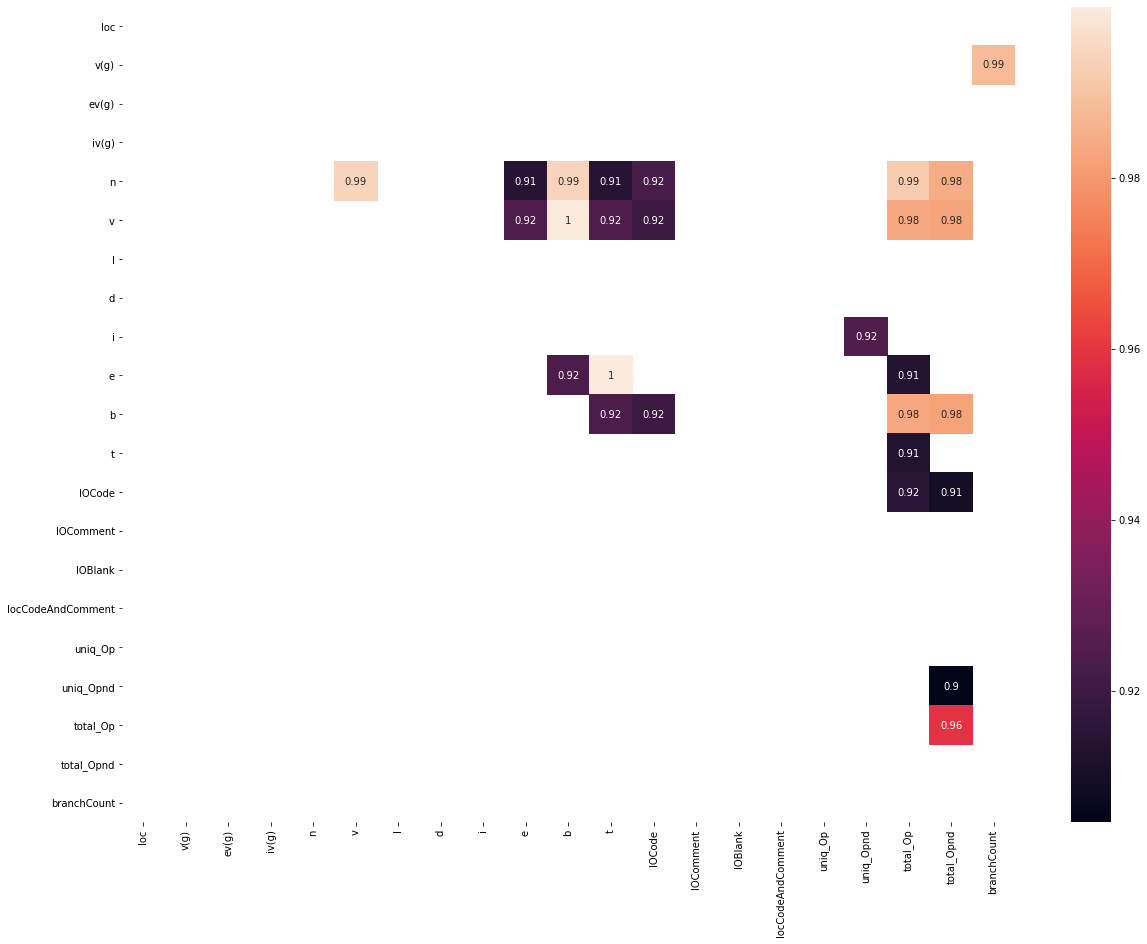

In [107]:
plot_heatmap(corr, 0.90)
plt.show()

In [0]:
def get_drop_columns(df, drop_threshold):
    upper = df.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > drop_threshold)]
    return to_drop

In [109]:
drop_90_corr_cols=get_drop_columns(corr, 0.90)
drop_90_corr_cols

['v',
 'e',
 'b',
 't',
 'lOCode',
 'uniq_Opnd',
 'total_Op',
 'total_Opnd',
 'branchCount']

In [0]:
X1=X.drop(drop_90_corr_cols, axis=1)

In [111]:
X1.shape

(7772, 12)

In [112]:
X.shape

(7772, 21)

In [113]:
y.shape

(7772,)

In [114]:
y.value_counts()

0    4601
1    3171
Name: defects, dtype: int64

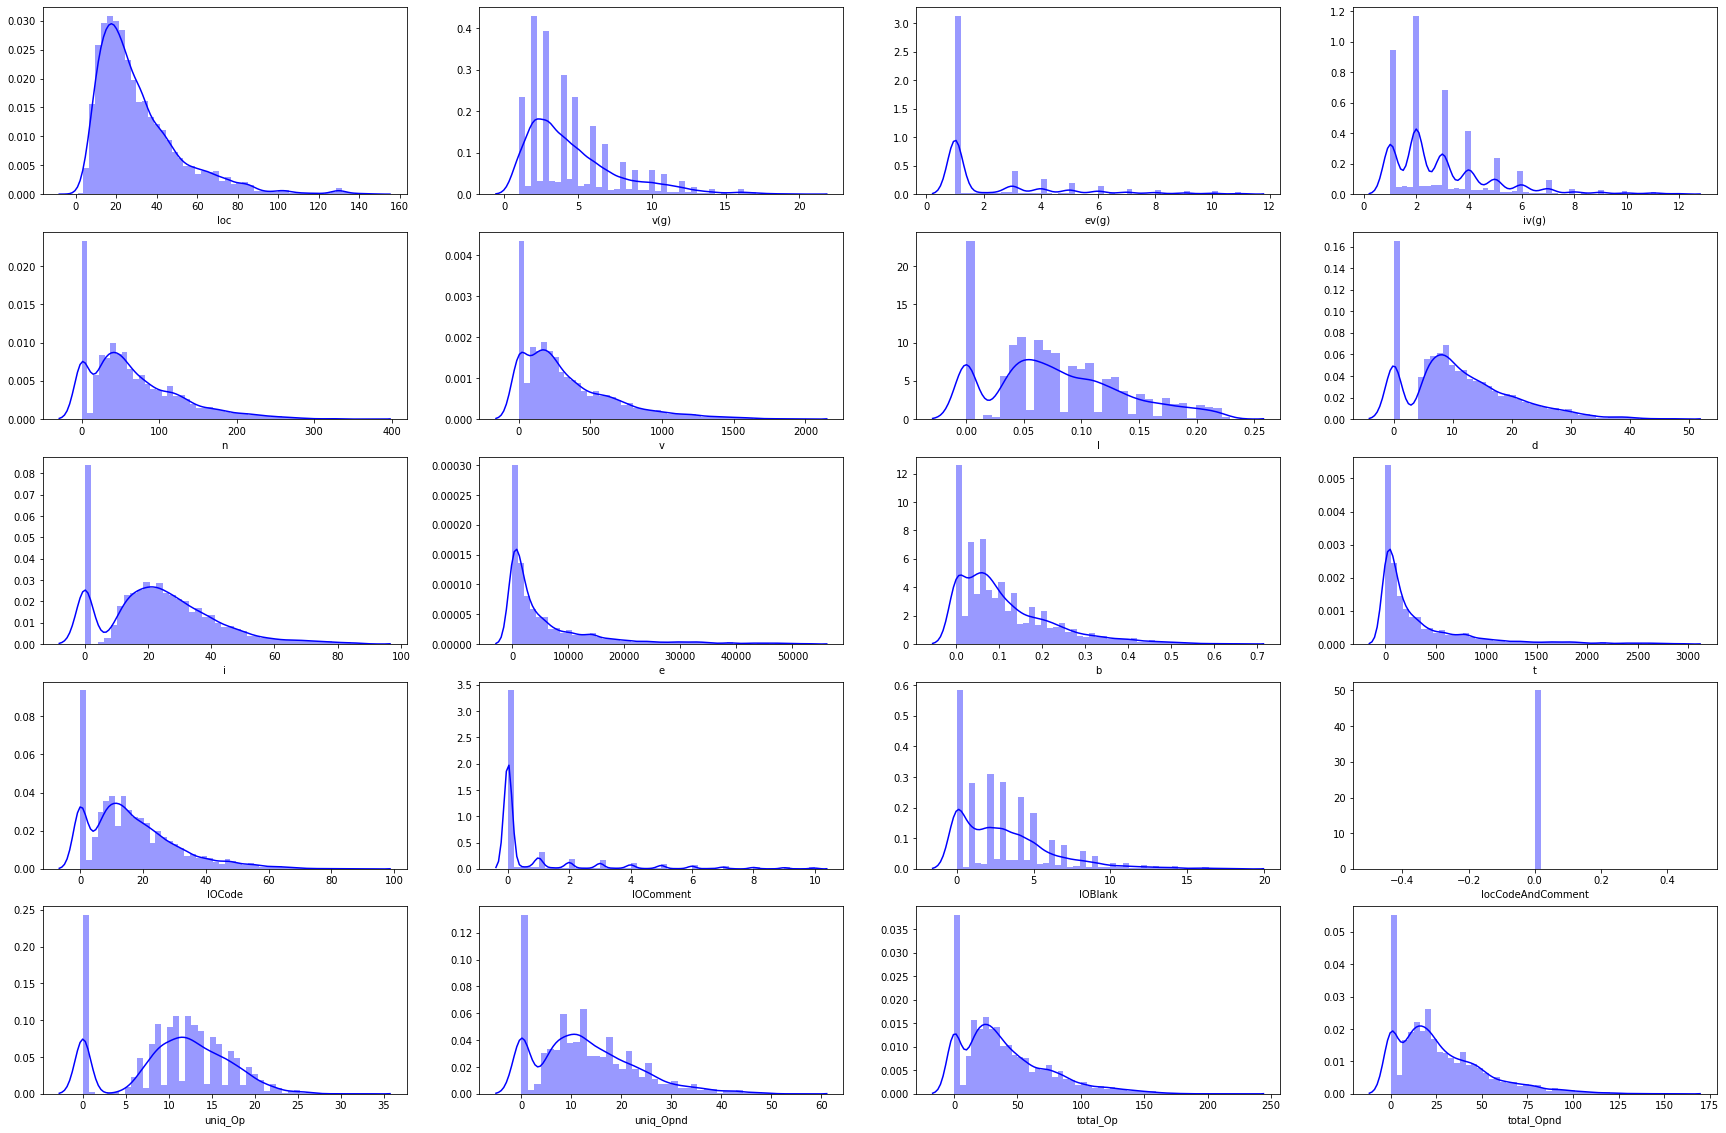

In [115]:
plot_columns_distribution(X, "Distribution", 'blue', 5, 4)
plt.show()

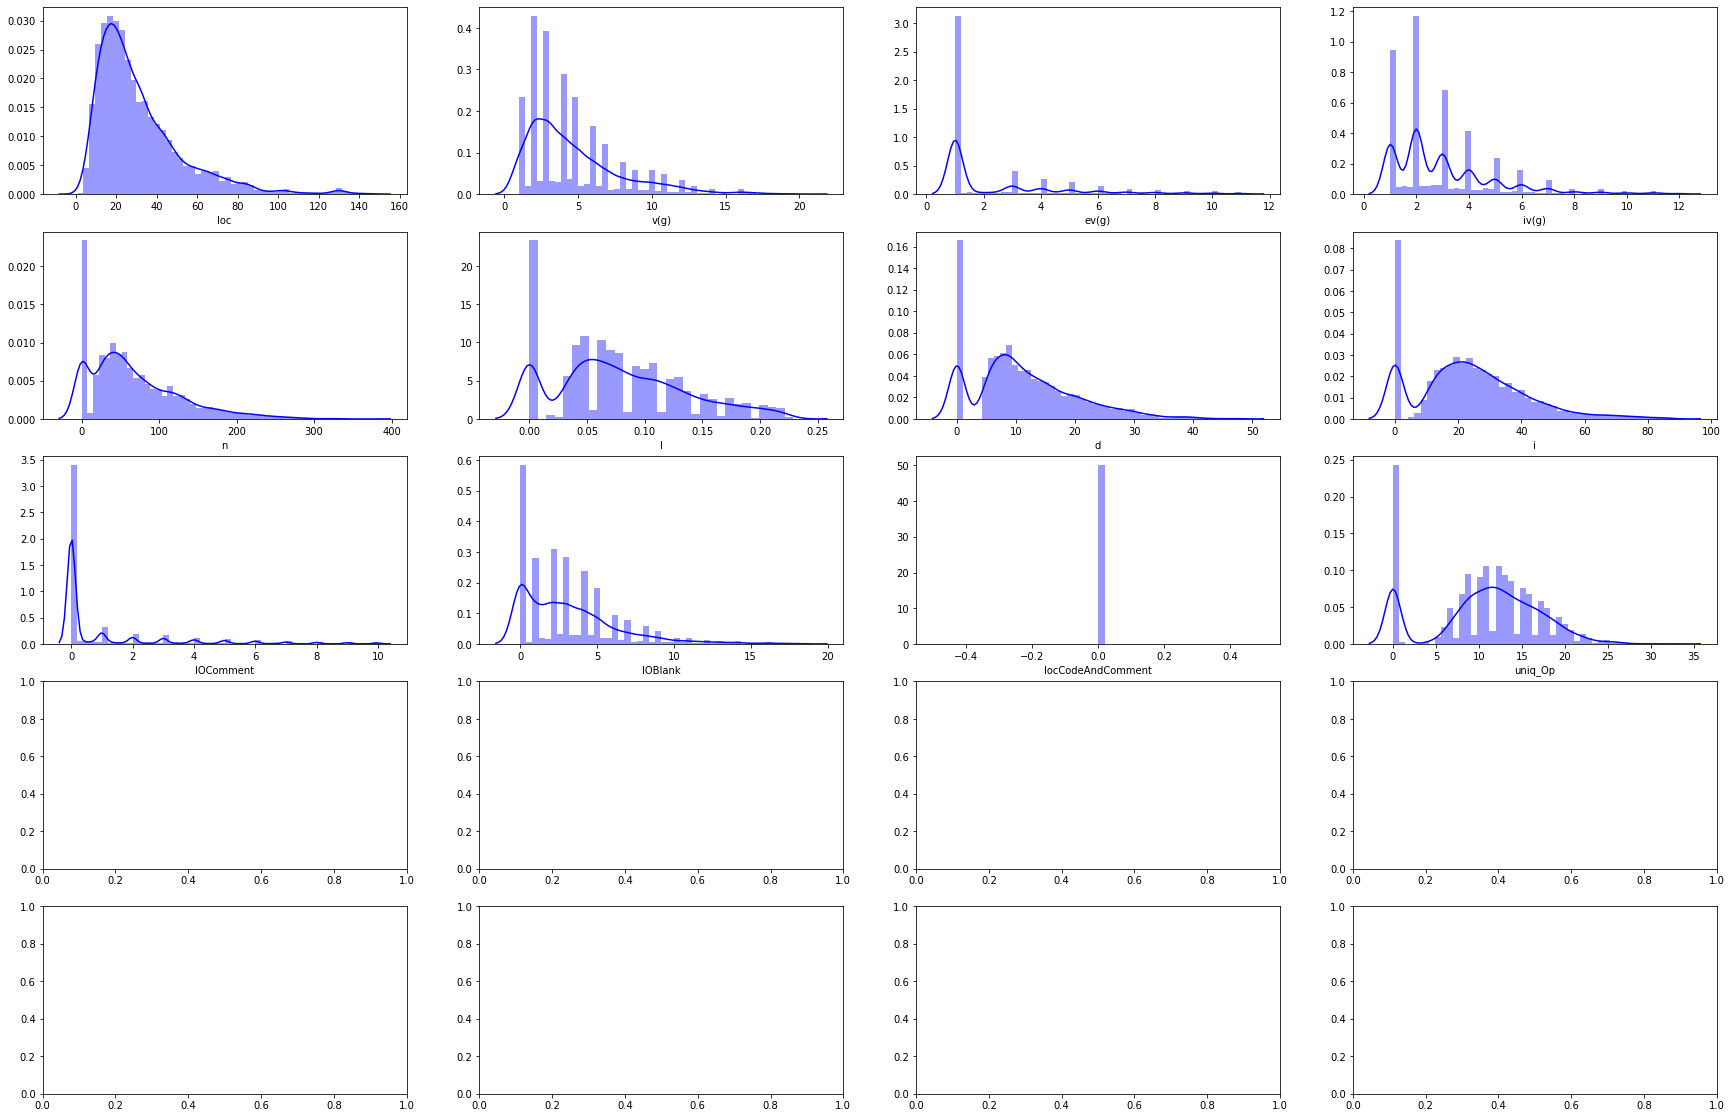

In [116]:
plot_columns_distribution(X1, "Distribution", 'blue', 5, 4)
plt.show()

**Modelling**

In [117]:
y.shape

(7772,)

In [118]:
X.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
dtype: int64

In [119]:
X1.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
l                    0
d                    0
i                    0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
dtype: int64

In [0]:
def Model_build_predict_normalize(X, y, imbal, classifier):
    if imbal==True:
      oversample = SMOTE()
      X, y = oversample.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0) 
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    scaler=Normalizer()
    X_std_train=scaler.fit_transform(X_train)
    X_std_test=scaler.transform(X_test)
    
    clf=classifier()
    clf=clf.fit(X_train, y_train)
    print("Estimator :\n", clf)
    
    y_pred_train=clf.predict(X_train)
    y_pred_test=clf.predict(X_test)
    
    print("\n")
    print("TRAIN DATA STATISTICS:\n")
    print("Accuracy : ", metrics.accuracy_score(y_train, y_pred_train))
    print("Recall : ", metrics.recall_score(y_train, y_pred_train))
    print("Precision : ", metrics.precision_score(y_train, y_pred_train))
    print("F1 score : ", metrics.f1_score(y_train, y_pred_train))
    print("\n\nConfusion matrix : \n", metrics.confusion_matrix(y_train, y_pred_train))
    print("\n\nClassification report : \n", metrics.classification_report(y_train, y_pred_train))
    
    print("\n\n")
    print("TEST DATA STATISTICS:\n")
    print("Accuracy : ", metrics.accuracy_score(y_test, y_pred_test))
    print("Recall : ", metrics.recall_score(y_test, y_pred_test))
    print("Precision : ", metrics.precision_score(y_test, y_pred_test))
    print("F1 score : ", metrics.f1_score(y_test, y_pred_test))
    print("\n\nConfusion matrix : \n", metrics.confusion_matrix(y_test, y_pred_test))
    print("\n\nClassification report : \n", metrics.classification_report(y_test, y_pred_test))

In [0]:
def Model_build_predict_min_max(X, y, imbal, classifier):
    if imbal==True:
      oversample = SMOTE()
      X, y = oversample.fit_resample(X, y)
      
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0) 
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    scaler=MinMaxScaler()
    X_std_train=scaler.fit_transform(X_train)
    X_std_test=scaler.transform(X_test)
    
    clf=classifier()
    clf=clf.fit(X_train, y_train)
    print("Estimator :\n", clf)
    
    y_pred_train=clf.predict(X_train)
    y_pred_test=clf.predict(X_test)
    
    print("\n")
    print("TRAIN DATA STATISTICS:\n")
    print("Accuracy : ", metrics.accuracy_score(y_train, y_pred_train))
    print("Recall : ", metrics.recall_score(y_train, y_pred_train))
    print("Precision : ", metrics.precision_score(y_train, y_pred_train))
    print("F1 score : ", metrics.f1_score(y_train, y_pred_train))
    print("\n\nClassification report : \n", metrics.classification_report(y_train, y_pred_train))
    print("\n\nClassification report : \n", metrics.classification_report(y_train, y_pred_train))
    
    print("\n\n")
    print("TEST DATA STATISTICS:\n")
    print("Accuracy : ", metrics.accuracy_score(y_test, y_pred_test))
    print("Recall : ", metrics.recall_score(y_test, y_pred_test))
    print("Precision : ", metrics.precision_score(y_test, y_pred_test))
    print("F1 score : ", metrics.f1_score(y_test, y_pred_test))
    print("\n\nConfusion matrix : \n", pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_test), 
                                        columns=['Predict No','Predict Yes'], index=['Actual No','Actual Yes']))
    print("\n\nClassification report : \n", metrics.classification_report(y_test, y_pred_test))

**Logistic Regeression**

In [122]:
Model_build_predict_normalize(X, y, 0, LogisticRegression)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.6318159884188516
Recall :  0.38256087981146897
Precision :  0.5759905381431106
F1 score :  0.45975926362992686


Confusion matrix : 
 [[2954  717]
 [1572  974]]


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.80      0.72      3671
           1       0.58      0.38      0.46      2546

    accuracy                           0.63      6217
   macro avg       0.61      0.59      0.59      6217
weighted avg       0.62      0.63      0.61      6217




TEST DATA STATISTICS:

Accuracy :  0.6115755627009646
Recall :  

In [0]:
#Model_build_predict_normalize(X, y, 1, LogisticRegression)

In [124]:
Model_build_predict_min_max(X, y, 0, LogisticRegression)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.6318159884188516
Recall :  0.38256087981146897
Precision :  0.5759905381431106
F1 score :  0.45975926362992686


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.80      0.72      3671
           1       0.58      0.38      0.46      2546

    accuracy                           0.63      6217
   macro avg       0.61      0.59      0.59      6217
weighted avg       0.62      0.63      0.61      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.80 

In [0]:
#Model_build_predict_min_max(X, y, 1, LogisticRegression)

In [126]:
Model_build_predict_normalize(X1, y, 0, LogisticRegression)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.632620234839955
Recall :  0.2831893165750196
Precision :  0.6110169491525423
F1 score :  0.38701019860440145


Confusion matrix : 
 [[3212  459]
 [1825  721]]


Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.87      0.74      3671
           1       0.61      0.28      0.39      2546

    accuracy                           0.63      6217
   macro avg       0.62      0.58      0.56      6217
weighted avg       0.63      0.63      0.59      6217




TEST DATA STATISTICS:

Accuracy :  0.6263665594855305
Recall :  0.

In [0]:
#Model_build_predict_normalize(X1, y, 1, LogisticRegression)

In [128]:
Model_build_predict_min_max(X1, y, 0, LogisticRegression)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.632620234839955
Recall :  0.2831893165750196
Precision :  0.6110169491525423
F1 score :  0.38701019860440145


Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.87      0.74      3671
           1       0.61      0.28      0.39      2546

    accuracy                           0.63      6217
   macro avg       0.62      0.58      0.56      6217
weighted avg       0.63      0.63      0.59      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.87   

In [0]:
#Model_build_predict_min_max(X1, y, 1, LogisticRegression)

**Decision Tree Classifier**

In [130]:
Model_build_predict_normalize(X, y, 0, DecisionTreeClassifier)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.9878240377062059
Precision :  1.0
F1 score :  0.9938747283145624


Confusion matrix : 
 [[3671    0]
 [  31 2515]]


Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3671
           1       1.00      0.99      0.99      2546

    accuracy                           1.00      6217
   macro avg       1.00      0.99      0.99      6217
weighted avg       1.00      1.00     

In [0]:
#Model_build_predict_normalize(X, y, 1, DecisionTreeClassifier)

In [132]:
Model_build_predict_min_max(X, y, 0, DecisionTreeClassifier)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.9878240377062059
Precision :  1.0
F1 score :  0.9938747283145624


Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3671
           1       1.00      0.99      0.99      2546

    accuracy                           1.00      6217
   macro avg       1.00      0.99      0.99      6217
weighted avg       1.00      1.00      1.00      6217



Classification report : 
      

In [0]:
#Model_build_predict_min_max(X, y, 1, DecisionTreeClassifier)

In [136]:
Model_build_predict_normalize(X1, y, 0, DecisionTreeClassifier)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.9878240377062059
Precision :  1.0
F1 score :  0.9938747283145624


Confusion matrix : 
 [[3671    0]
 [  31 2515]]


Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3671
           1       1.00      0.99      0.99      2546

    accuracy                           1.00      6217
   macro avg       1.00      0.99      0.99      6217
weighted avg       1.00      1.00     

In [0]:
#Model_build_predict_normalize(X1, y, 1, DecisionTreeClassifier)

In [137]:
Model_build_predict_min_max(X1, y, 0, DecisionTreeClassifier)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.9878240377062059
Precision :  1.0
F1 score :  0.9938747283145624


Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3671
           1       1.00      0.99      0.99      2546

    accuracy                           1.00      6217
   macro avg       1.00      0.99      0.99      6217
weighted avg       1.00      1.00      1.00      6217



Classification report : 
      

In [0]:
#Model_build_predict_min_max(X1, y, 1, DecisionTreeClassifier)

**Random Forest Classifier**

In [139]:
Model_build_predict_normalize(X, y, 0, RandomForestClassifier)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.9913589945011784
Precision :  0.9964469009080142
F1 score :  0.9938964363063595


Confusion matrix : 
 [[3662    9]
 [  22 2524]]


Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3671
           1       1.00      0.99      0.99      2546

    accurac

In [0]:
#Model_build_predict_normalize(X, y, 1, RandomForestClassifier)

In [141]:
Model_build_predict_min_max(X, y, 0, RandomForestClassifier)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.9921445404556166
Precision :  0.9956641702798581
F1 score :  0.993901239425536


Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3671
           1       1.00      0.99      0.99      2546

    accuracy                           1.00      6217
   macro

In [0]:
#Model_build_predict_min_max(X, y, 1, RandomForestClassifier)

In [143]:
Model_build_predict_normalize(X1, y, 0, RandomForestClassifier)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.9925373134328358
Precision :  0.9952737298148877
F1 score :  0.9939036381514258


Confusion matrix : 
 [[3659   12]
 [  19 2527]]


Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3671
           1       1.00      0.99      0.99      2546

    accurac

In [0]:
#Model_build_predict_normalize(X1, y, 1, RandomForestClassifier)

In [145]:
Model_build_predict_min_max(X1, y, 0, RandomForestClassifier)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


TRAIN DATA STATISTICS:

Accuracy :  0.9950136721891587
Recall :  0.992930086410055
Precision :  0.9948839039748131
F1 score :  0.9939060349911539


Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3671
           1       0.99      0.99      0.99      2546

    accuracy                           1.00      6217
   macro

In [0]:
#Model_build_predict_min_max(X1, y, 1, RandomForestClassifier)

**KNN**

In [147]:
Model_build_predict_normalize(X, y, 0, KNeighborsClassifier)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


TRAIN DATA STATISTICS:

Accuracy :  0.8212964452308187
Recall :  0.8507462686567164
Precision :  0.7476700034518468
F1 score :  0.7958846224508543


Confusion matrix : 
 [[2940  731]
 [ 380 2166]]


Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      3671
           1       0.75      0.85      0.80      2546

    accuracy                           0.82      6217
   macro avg       0.82      0.83      0.82      6217
weighted avg       0.83      0.82      0.82      6217




TEST DATA STATISTICS:

Accuracy :  0.6938906752411576
Recall :  0.7328
Precision :  0.5971316818774446
F1 score :  0.6580459770114944


Confusion matrix : 
 [[621 309]
 [167 458]]


Classification report :

In [0]:
#Model_build_predict_normalize(X, y, 1, KNeighborsClassifier)

In [149]:
Model_build_predict_min_max(X, y, 0, KNeighborsClassifier)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


TRAIN DATA STATISTICS:

Accuracy :  0.8212964452308187
Recall :  0.8507462686567164
Precision :  0.7476700034518468
F1 score :  0.7958846224508543


Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      3671
           1       0.75      0.85      0.80      2546

    accuracy                           0.82      6217
   macro avg       0.82      0.83      0.82      6217
weighted avg       0.83      0.82      0.82      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      3671
           1       0.75      0.85      0.80      2546

    accuracy                           0.82      6217
   macro avg

In [0]:
#Model_build_predict_min_max(X, y, 1, KNeighborsClassifier)

In [151]:
Model_build_predict_normalize(X1, y, 0, KNeighborsClassifier)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


TRAIN DATA STATISTICS:

Accuracy :  0.8084285024931639
Recall :  0.8460329929300864
Precision :  0.7294277006434134
F1 score :  0.7834151663938898


Confusion matrix : 
 [[2872  799]
 [ 392 2154]]


Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      3671
           1       0.73      0.85      0.78      2546

    accuracy                           0.81      6217
   macro avg       0.80      0.81      0.81      6217
weighted avg       0.82      0.81      0.81      6217




TEST DATA STATISTICS:

Accuracy :  0.6990353697749196
Recall :  0.7264
Precision :  0.6045272969374168
F1 score :  0.6598837209302325


Confusion matrix : 
 [[633 297]
 [171 454]]


Classification report :

In [0]:
#Model_build_predict_normalize(X1, y, 1, KNeighborsClassifier)

In [153]:
Model_build_predict_min_max(X1, y, 0, KNeighborsClassifier)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


TRAIN DATA STATISTICS:

Accuracy :  0.8084285024931639
Recall :  0.8460329929300864
Precision :  0.7294277006434134
F1 score :  0.7834151663938898


Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      3671
           1       0.73      0.85      0.78      2546

    accuracy                           0.81      6217
   macro avg       0.80      0.81      0.81      6217
weighted avg       0.82      0.81      0.81      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      3671
           1       0.73      0.85      0.78      2546

    accuracy                           0.81      6217
   macro avg

In [0]:
#Model_build_predict_min_max(X1, y, 1, KNeighborsClassifier)

**SVC**

In [155]:
Model_build_predict_normalize(X, y, 0, SVC)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


TRAIN DATA STATISTICS:

Accuracy :  0.5920862152163423
Recall :  0.02474469756480754
Precision :  0.5431034482758621
F1 score :  0.047332832456799395


Confusion matrix : 
 [[3618   53]
 [2483   63]]


Classification report : 
               precision    recall  f1-score   support

           0       0.59      0.99      0.74      3671
           1       0.54      0.02      0.05      2546

    accuracy                           0.59      6217
   macro avg       0.57      0.51      0.39      6217
weighted avg       0.57      0.59      0.46      6217




TEST DATA STATISTICS:

Accuracy :  0.6077170418006431
Recall :  0.04
Precision :  0.7142857142857143
F1 score :  0.07575757575757576


Conf

In [0]:
#Model_build_predict_normalize(X, y, 1, SVC)

In [157]:
Model_build_predict_min_max(X, y, 0, SVC)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


TRAIN DATA STATISTICS:

Accuracy :  0.5920862152163423
Recall :  0.02474469756480754
Precision :  0.5431034482758621
F1 score :  0.047332832456799395


Classification report : 
               precision    recall  f1-score   support

           0       0.59      0.99      0.74      3671
           1       0.54      0.02      0.05      2546

    accuracy                           0.59      6217
   macro avg       0.57      0.51      0.39      6217
weighted avg       0.57      0.59      0.46      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.59      0.99      0.74      3671
           1       0.54      0.02      0.05      2546



In [0]:
#Model_build_predict_min_max(X, y, 1, SVC)

In [159]:
Model_build_predict_normalize(X1, y, 0, SVC)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


TRAIN DATA STATISTICS:

Accuracy :  0.6321376869872929
Recall :  0.27297721916732126
Precision :  0.614500442086649
F1 score :  0.378025564318738


Confusion matrix : 
 [[3235  436]
 [1851  695]]


Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.88      0.74      3671
           1       0.61      0.27      0.38      2546

    accuracy                           0.63      6217
   macro avg       0.63      0.58      0.56      6217
weighted avg       0.63      0.63      0.59      6217




TEST DATA STATISTICS:

Accuracy :  0.6360128617363344
Recall :  0.2784
Precision :  0.6020761245674741
F1 score :  0.38074398249452956


Confus

In [0]:
#Model_build_predict_normalize(X1, y, 1, SVC)

In [161]:
Model_build_predict_min_max(X1, y, 0, SVC)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


TRAIN DATA STATISTICS:

Accuracy :  0.6321376869872929
Recall :  0.27297721916732126
Precision :  0.614500442086649
F1 score :  0.378025564318738


Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.88      0.74      3671
           1       0.61      0.27      0.38      2546

    accuracy                           0.63      6217
   macro avg       0.63      0.58      0.56      6217
weighted avg       0.63      0.63      0.59      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.88      0.74      3671
           1       0.61      0.27      0.38      2546

    

In [0]:
#Model_build_predict_min_max(X1, y, 1, SVC)

**Gaussian Naive Bayes**

In [163]:
Model_build_predict_normalize(X, y, 0, GaussianNB)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 GaussianNB(priors=None, var_smoothing=1e-09)


TRAIN DATA STATISTICS:

Accuracy :  0.6123532250281486
Recall :  0.35860172820109976
Precision :  0.5402366863905326
F1 score :  0.43106704438149196


Confusion matrix : 
 [[2894  777]
 [1633  913]]


Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.79      0.71      3671
           1       0.54      0.36      0.43      2546

    accuracy                           0.61      6217
   macro avg       0.59      0.57      0.57      6217
weighted avg       0.60      0.61      0.59      6217




TEST DATA STATISTICS:

Accuracy :  0.6154340836012862
Recall :  0.3632
Precision :  0.531615925058548
F1 score :  0.4315589353612167


Confusion matrix : 
 [[730 200]
 [398 227]]


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71       930
           1       0.53      

In [0]:
#Model_build_predict_normalize(X, y, 1, GaussianNB)

In [165]:
Model_build_predict_min_max(X, y, 0, GaussianNB)

(6217, 21)
(1555, 21)
(6217,)
(1555,)
Estimator :
 GaussianNB(priors=None, var_smoothing=1e-09)


TRAIN DATA STATISTICS:

Accuracy :  0.6123532250281486
Recall :  0.35860172820109976
Precision :  0.5402366863905326
F1 score :  0.43106704438149196


Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.79      0.71      3671
           1       0.54      0.36      0.43      2546

    accuracy                           0.61      6217
   macro avg       0.59      0.57      0.57      6217
weighted avg       0.60      0.61      0.59      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.79      0.71      3671
           1       0.54      0.36      0.43      2546

    accuracy                           0.61      6217
   macro avg       0.59      0.57      0.57      6217
weighted avg       0.60      0.61      0.59      6217




TEST DATA STATISTICS:

Accuracy :  0.615

In [0]:
#Model_build_predict_min_max(X, y, 1, GaussianNB)

In [167]:
Model_build_predict_normalize(X1, y, 0, GaussianNB)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 GaussianNB(priors=None, var_smoothing=1e-09)


TRAIN DATA STATISTICS:

Accuracy :  0.6202348399549622
Recall :  0.39630793401413983
Precision :  0.5504637206764866
F1 score :  0.46083580726193196


Confusion matrix : 
 [[2847  824]
 [1537 1009]]


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71      3671
           1       0.55      0.40      0.46      2546

    accuracy                           0.62      6217
   macro avg       0.60      0.59      0.58      6217
weighted avg       0.61      0.62      0.61      6217




TEST DATA STATISTICS:

Accuracy :  0.6205787781350482
Recall :  0.3888
Precision :  0.5388026607538803
F1 score :  0.45167286245353155


Confusion matrix : 
 [[722 208]
 [382 243]]


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71       930
           1       0.54    

In [0]:
#Model_build_predict_normalize(X1, y, 1, GaussianNB)

In [169]:
Model_build_predict_min_max(X1, y, 0, GaussianNB)

(6217, 12)
(1555, 12)
(6217,)
(1555,)
Estimator :
 GaussianNB(priors=None, var_smoothing=1e-09)


TRAIN DATA STATISTICS:

Accuracy :  0.6202348399549622
Recall :  0.39630793401413983
Precision :  0.5504637206764866
F1 score :  0.46083580726193196


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71      3671
           1       0.55      0.40      0.46      2546

    accuracy                           0.62      6217
   macro avg       0.60      0.59      0.58      6217
weighted avg       0.61      0.62      0.61      6217



Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71      3671
           1       0.55      0.40      0.46      2546

    accuracy                           0.62      6217
   macro avg       0.60      0.59      0.58      6217
weighted avg       0.61      0.62      0.61      6217




TEST DATA STATISTICS:

Accuracy :  0.620

In [0]:
#Model_build_predict_min_max(X1, y, 1, GaussianNB)

**Parameterized modelling**

In [0]:
from sklearn.decomposition import PCA
def get_PCA_components(X, y):

  sc=MinMaxScaler()
  X_sc=sc.fit_transform(X)
  pca=PCA(0.95).fit(X_sc)

  print("Components", pca.n_components_)
  print("Explained Variance", pca.explained_variance_ratio_)

  var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
  plt.ylabel('% Variance Explained')
  plt.xlabel('Number of features')
  plt.title('PCA analysis')
  plt.ylim(30,100.5)
  plt.style.context('seaborn-whitegrid')
  plt.plot(var)

Components 8
Explained Variance [0.51552783 0.21849356 0.06231003 0.05782922 0.04802732 0.02713544
 0.02027343 0.01756836]


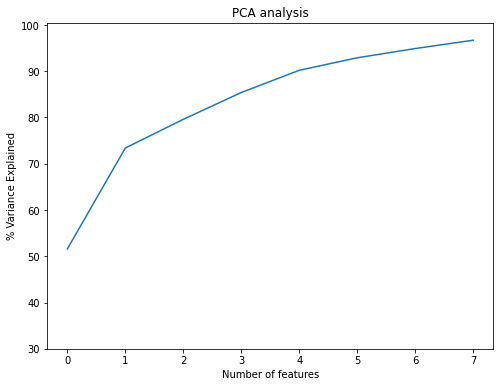

In [172]:
get_PCA_components(X,y)

Components 7
Explained Variance [0.35492395 0.29057732 0.09228321 0.08676331 0.07049166 0.03812009
 0.0260545 ]


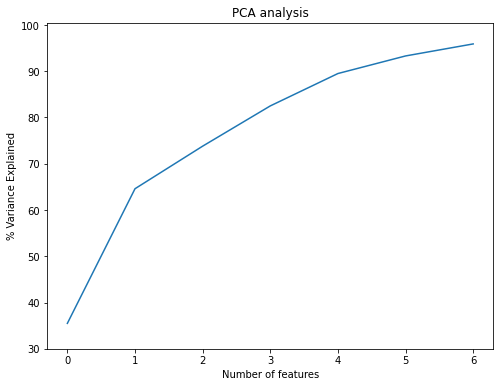

In [173]:
get_PCA_components(X1,y)

In [0]:
def train_predict_ml_model_param(X_train, y_train, ref_score):
 
  #Initialize the pipeline with any estimator you like
  pipe=Pipeline(steps=[('classifier', RandomForestClassifier())])
  param_grid=[{
                  'classifier':[LogisticRegressionCV()],
                  'classifier__penalty' : ['l1', 'l2'],
                  'classifier__cv' : range(5,20,5),
                  'classifier__solver' : ['liblinear','sag','saga'],
                  'classifier__random_state':[0]
                },
               {
                  'classifier':[DecisionTreeClassifier()],
                  'classifier__criterion':['gini','entropy'],
                  'classifier__splitter':['best','random'],
                  'classifier__max_depth':range(2,20,2),
                  'classifier__min_samples_split':range(2,1000, 10),
                  'classifier__min_samples_leaf':range(1,20, 1),
                  'classifier__max_features':['auto','sqrt','log2'],
                  'classifier__random_state':[0]
               },
               {
                  'classifier':[RandomForestClassifier()],
                  'classifier__n_estimators': [10, 100, 1000],
                  'classifier__criterion':['gini','entropy'],
                  'classifier__max_depth':range(2,20,2),
                  'classifier__min_samples_split':range(2,1000, 10),
                  'classifier__min_samples_leaf':range(1,20, 1),
                  'classifier__max_features':['auto','sqrt','log2'],
                  'classifier__random_state':[0]
               },
               {
                  'classifier':[KNeighborsClassifier()],
                  'classifier__n_neighbors':range(1, 21, 2),
                  'classifier__weights':['uniform', 'distance'],
                  'classifier__metric':['euclidean', 'manhattan', 'minkowski'],
                  'classifier__algorithm':['auto','ball_tree','kd_tree','brute'],
                  'classifier__n_jobs':[-1]
               },
               {
                   'classifier':[SVC()],
                   'classifier__kernel':['poly', 'rbf', 'sigmoid'],
                   'classifier__C':[50, 10, 1.0, 0.1, 0.01],
                   'classifier__gamma':['scale','auto']
               },
               {
                   'classifier':[GaussianNB()],
               },
  ]
  scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score),
    'accuracy_score': metrics.make_scorer(metrics.accuracy_score),
    'f1_score': metrics.make_scorer(metrics.f1_score)
  }
  #clf = GridSearchCV(pipe, param_grid = param_grid, cv =3, verbose=True, n_jobs=-1)
  clf = RandomizedSearchCV(pipe, n_iter=10, param_distributions = param_grid, cv =10, verbose=True, n_jobs=-1, return_train_score=True, refit=ref_score, scoring=scorers)

  best_clf = clf.fit(X_train, y_train)

  return best_clf

In [0]:
#df  -> input dataframe
#test_size -> test size data to split upon
# n -> number of components for PCA or SelectKBest
#flag -> 0 - SelectKBest, 1 - PCA
def predict_gridsearch_result(X, y, test_siz, n, flag, imbal, ref_score, minmax):

  if (imbal==True):
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)

  
  #le=LabelEncoder()
  #y=le.fit_transform(y)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_siz, random_state = 0)  
  print(X_train.shape)
  print(X_test.shape)
  print(y_train.shape)
  print(y_test.shape)

  if (minmax==True):
    scaler=MinMaxScaler()
  else:
    scaler=Normalizer()
  X_std_train=scaler.fit_transform(X_train)
  X_std_test=scaler.transform(X_test)

  if (flag==0): #KBEST
    print ("SelectKBest")
    fs=SelectKBest(score_func=chi2, k=n)
    X_new=fs.fit_transform(X_std_train, y_train)
    X_std_test=fs.transform(X_std_test)
  else: #PCA
    print ("PCA")
    pca=PCA(n_components=n, random_state=0)
    X_new=pca.fit_transform(X_std_train)
    X_std_test=pca.transform(X_std_test)

  best_clf=train_predict_ml_model_param(X_new, y_train, ref_score)

  y_pred=best_clf.predict(X_std_test)

  
  y_pred_proba = best_clf.predict_proba(X_std_test)
  preds = y_pred_proba[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)
  print(roc_auc)

  plt.figure()
  plt.plot(fpr, tpr, label='AUC ROC (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")

  print(" START BEST MODEL STATS :\n")
  print("Best estimator : \n", best_clf.best_estimator_)
  print("-----------------------------------------")
  print('Model accuracy is :',best_clf.score(X_std_test, y_test))
  print("-----------------------------------------")
  print('Best parameters : \n', best_clf.best_estimator_.get_params())
  print("-----------------------------------------")
  #print('Mean train accuracy : ', best_clf.cv_results_['mean_train_score'].mean())
  print("-----------------------------------------")
  #print('Mean test accuracy : ', best_clf.cv_results_['mean_test_score'].mean())
  print("-----------------------------------------")
  print('Recall : ', metrics.recall_score(y_test, y_pred))
  print("-----------------------------------------")
  print('Precison : ', metrics.precision_score(y_test, y_pred))
  print("-----------------------------------------")
  print('F1 score : ', metrics.f1_score(y_test, y_pred))
  print("-----------------------------------------")
  #print('Train and Test accuracy difference  : ', best_clf.cv_results_['mean_test_score'].mean()- best_clf.cv_results_['mean_train_score'].mean())
  print("-----------------------------------------")
  print('Mean fit Time  : ', best_clf.cv_results_['mean_fit_time'].mean())
  print("-----------------------------------------")
  print('AUC ROC score  : ', roc_auc)
  print("-----------------------------------------")
  print("-----------------------------------------")
  print("Confusion Matrix:\n", pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns=['False','True'], index=['False','True']))
  print("-----------------------------------------")
  print("-----------------------------------------")
  print('Classfication Report : \n', metrics.classification_report(y_test, y_pred))
  print("-----------------------------------------")
  print("-----------------------------------------")
  print(" END BEST MODEL STATS :\n")


  return

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


0.6191466666666667
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=4,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=13,
                                        min_samples_split=672,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=0,
                                        splitter='best'))],
         verbose=False)
-----------------------------------------
Model accuracy is : 0.6045197740112994
-----------------------------------------
B

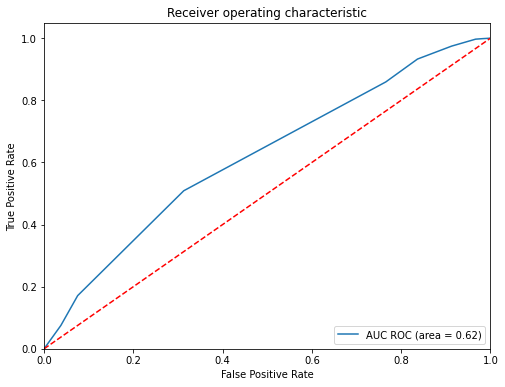

In [186]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'precision_score', 0)
plt.show()

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


0.6487802150537634
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=11,
                                        min_samples_split=862,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=0,
                                        splitter='best'))],
         verbose=False)
-----------------------------------------
Model accuracy is : 0.536
-----------------------------------------
Best parameters 

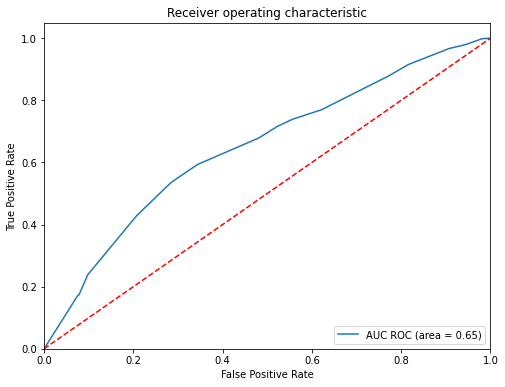

In [187]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'recall_score', 0)
plt.show()

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


0.6903810752688173
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=18, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=16,
                                        min_samples_split=372,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-----------

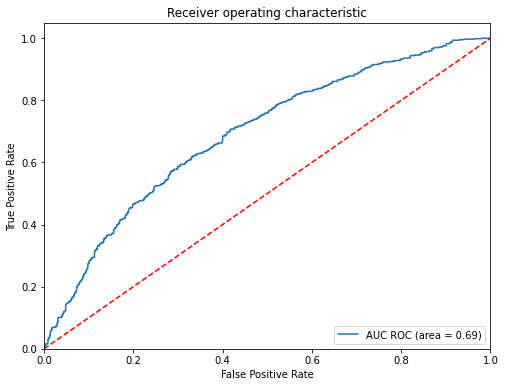

In [188]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'accuracy_score', 0)
plt.show()

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished


0.6937763440860215
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=14, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=15,
                                        min_samples_split=112,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
------------

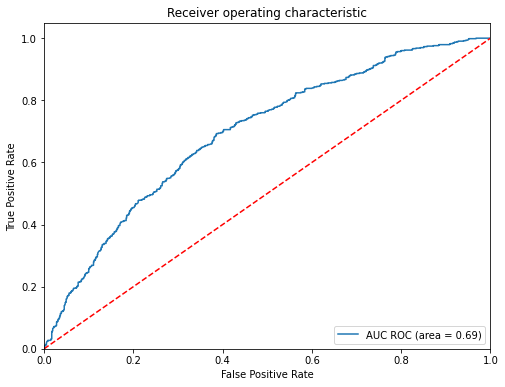

In [189]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'f1_score', 0)
plt.show()

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.8334993548387096
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=16,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=42,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=0,
                                        splitter='best'))],
         verbose=False)
-----------------------------------------
Model accuracy is : 0.7611111111111111
-----------------------------------------
Be

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.8s finished


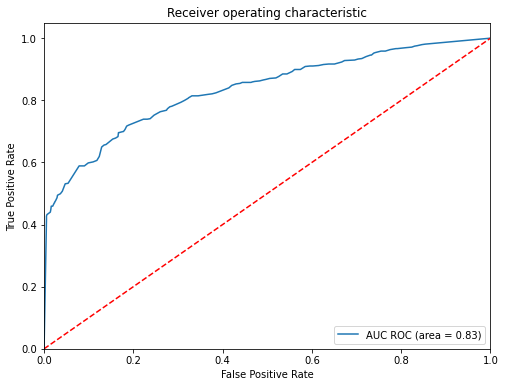

In [190]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'precision_score', 1)
plt.show()

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


0.8618468817204301
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=10, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=17,
                                        min_samples_split=32,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-------------

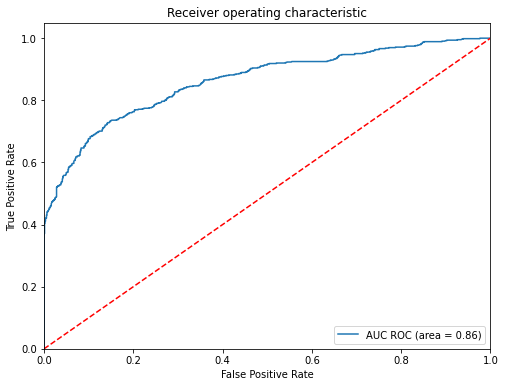

In [191]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'recall_score', 1)
plt.show()

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


0.8287982795698925
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=8, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=19,
                                        min_samples_split=612,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
------------

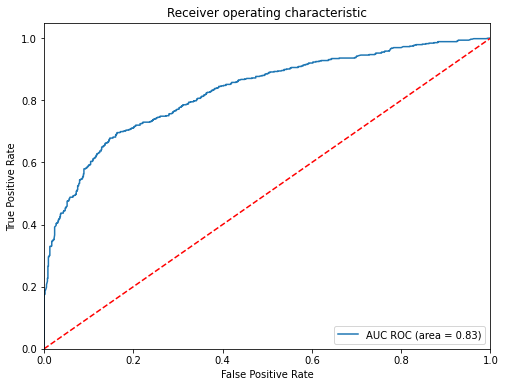

In [192]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'accuracy_score', 1)
plt.show()

(6217, 21)
(1555, 21)
(6217,)
(1555,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


0.8743913978494624
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=14, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=9,
                                        min_samples_split=112,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
------------

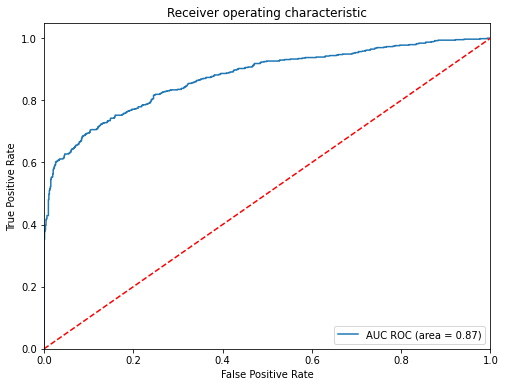

In [193]:
predict_gridsearch_result(X, y,.20, 8, 0, 0, 'f1_score', 1)
plt.show()

(11048, 21)
(2762, 21)
(11048,)
(2762,)
PCA
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.7s finished


0.7489081698167048
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=10, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=13,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-------------

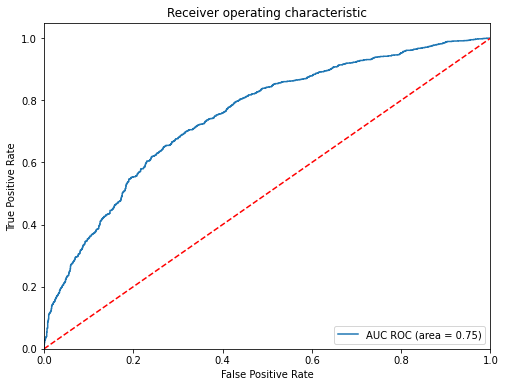

In [0]:
predict_gridsearch_result(X, y,.20, 7, 1, 1, 'precision_score')
plt.show()

(11048, 21)
(2762, 21)
(11048,)
(2762,)
PCA
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


0.6856753873203976
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=6, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=14,
                                        min_samples_split=922,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
----------------

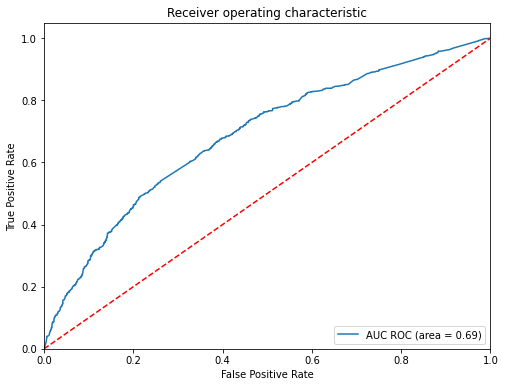

In [0]:
predict_gridsearch_result(X, y,.20, 7, 1, 1, 'recall_score')
plt.show()

(11048, 21)
(2762, 21)
(11048,)
(2762,)
PCA
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


0.7688614123136834
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=14, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=9, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-----------------------------------------
Model accur

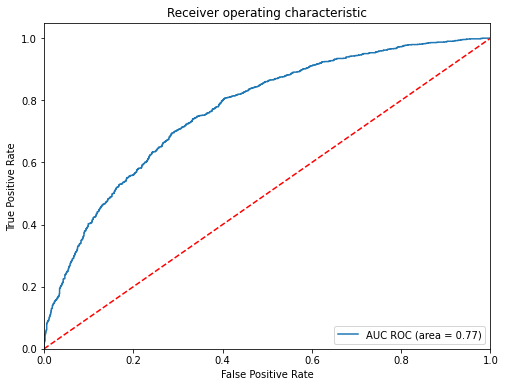

In [0]:
predict_gridsearch_result(X,y,.20, 7, 1, 1,  'accuracy_score')
plt.show()

(11048, 21)
(2762, 21)
(11048,)
(2762,)
PCA
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


0.7411006529474956
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=18, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=4,
                                        min_samples_split=202,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
---------------

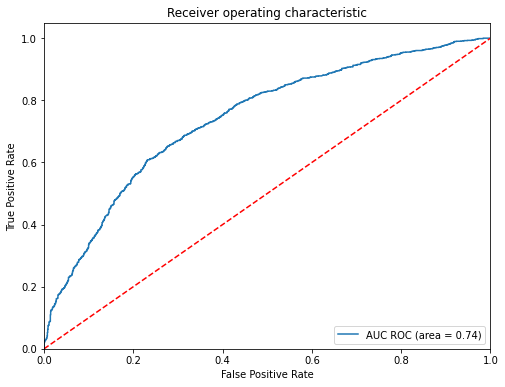

In [0]:
predict_gridsearch_result(X,y,.20, 7, 1, 1, 'f1_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


0.8880563272123002
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3,
                                        min_samples_split=42,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
----------------

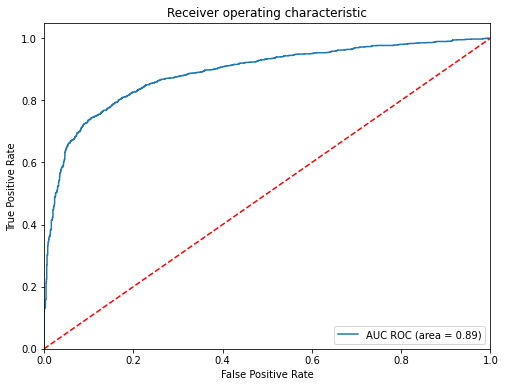

In [0]:
predict_gridsearch_result(X1, y,.20, 10, 0, 1, 'precision_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.0min finished


0.9036414621659729
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=18, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=11,
                                        min_samples_split=22,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-----------

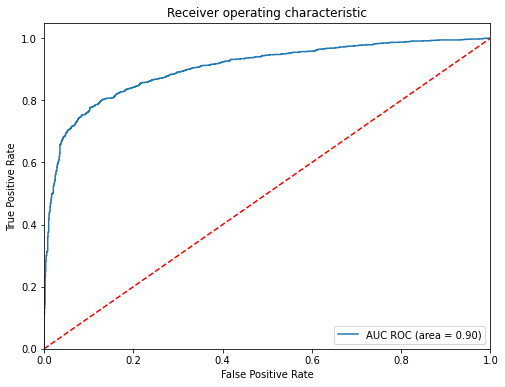

In [0]:
predict_gridsearch_result(X1, y,.20, 10, 0, 1, 'recall_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


0.8759058807237814
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=14, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=13,
                                        min_samples_split=82,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
----------------

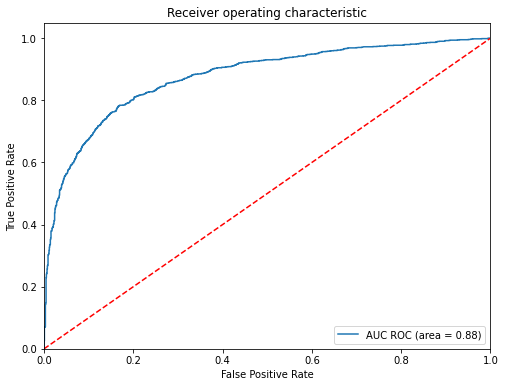

In [0]:
predict_gridsearch_result(X1,y,.20, 10, 0, 1,  'accuracy_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished


0.8866626242110918
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=10, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=13,
                                        min_samples_split=22,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-----------

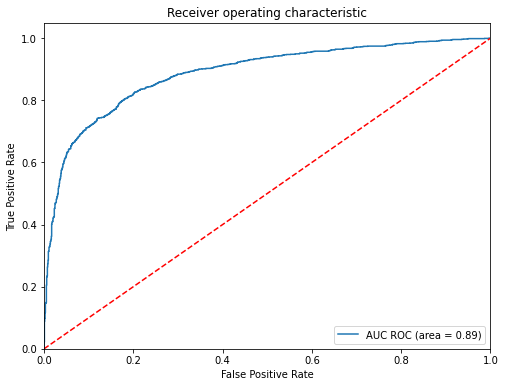

In [0]:
predict_gridsearch_result(X1,y,.20, 10, 0, 1, 'f1_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


0.8717667349268161
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=10, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=14,
                                        min_samples_split=22,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-----------

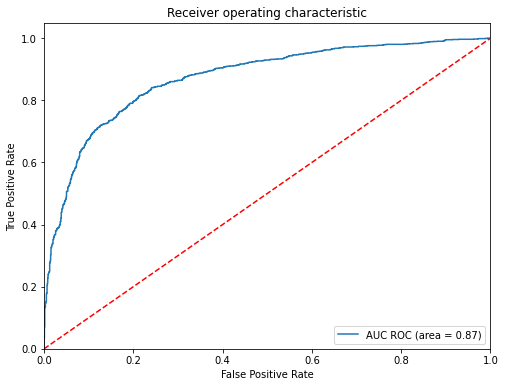

In [0]:
predict_gridsearch_result(X1, y,.20, 7, 0, 1, 'precision_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


0.8587109322545992
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=12, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=17,
                                        min_samples_split=62,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-------------

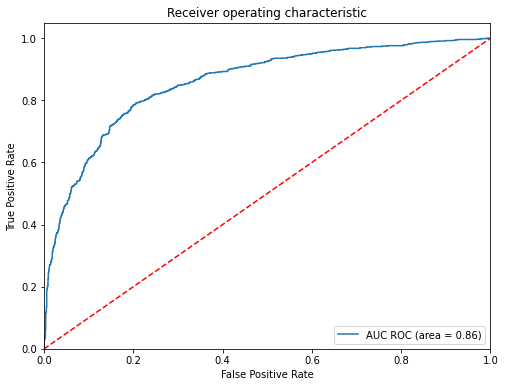

In [0]:
predict_gridsearch_result(X1, y,.20, 7, 0, 1, 'recall_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.9min finished


0.8567601676849739
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=16, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=19,
                                        min_samples_split=232,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
----------

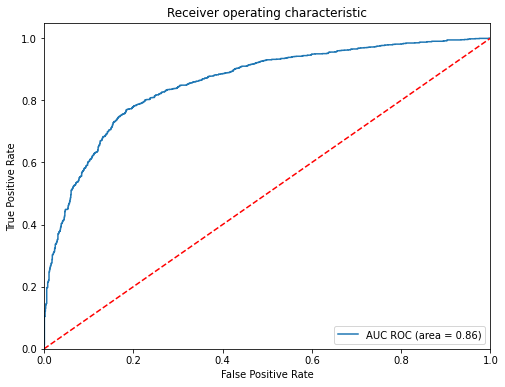

In [0]:
predict_gridsearch_result(X1,y,.20, 7, 0, 1,  'accuracy_score')
plt.show()

(11048, 14)
(2762, 14)
(11048,)
(2762,)
SelectKBest
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished


0.8985379494259433
 START BEST MODEL STATS :

Best estimator : 
 Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=14, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=4,
                                        min_samples_split=32,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
----------------

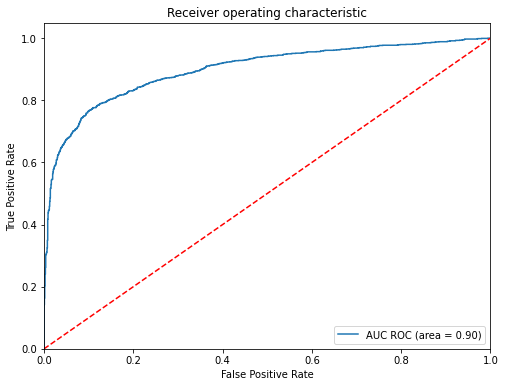

In [0]:
predict_gridsearch_result(X1,y,.20, 7, 0, 1, 'f1_score')
plt.show()

In our case - Recall has to be less as we need to reduce False negatives as we can't miss the defect from software.


Below model seems worked better compare to other algos

Train data

Accuracy :  0.9950136721891587

Recall :  0.9913589945011784

Precision :  0.9964469009080142

F1 score :  0.9938964363063595

Test data

Accuracy :  0.8598070739549839

Recall :  0.76

Precision :  0.8747697974217311

F1 score :  0.8133561643835615


Confusion matrix : 

 [[862  68]
 
 [150 475]]
 
 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)